# general dataset 2

Testing the general dataset and seeing if masking works

In [1]:
#some testing already done
from tqdm import tqdm
import torch
from src.dataloaders.datasets.general_dataset import GeneralDataset
dataset = GeneralDataset(
    split='train',
    preprocess=False,
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
    data_is_zarr=False,
    sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
    length=524288,
    load_in=True
)

In [2]:
dataset_mask = GeneralDataset(
    split='train',
    preprocess=False,
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
    data_is_zarr=False,
    sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
    length=524288,
    load_in=True,
    mlm=0.15,
    acc_mask=0.15,
)

In [3]:
#now we have the two datasets, let's see if when we load up random things how long it takes and then if they're the same
out = dataset[1022]
out_mask = dataset_mask[1022]
for i in range(len(out)):
    print(f'out[{i}] shape: {out[i].shape}')
    print(f'out_mask[{i}] shape: {out_mask[i].shape}')

out[0] shape: torch.Size([5, 524288])
out_mask[0] shape: torch.Size([6, 524288])
out[1] shape: torch.Size([1, 524288])
out_mask[1] shape: torch.Size([2, 524288])
out[2] shape: torch.Size([0])
out_mask[2] shape: torch.Size([6, 524288])
out[3] shape: torch.Size([0])
out_mask[3] shape: torch.Size([2, 524288])


In [4]:
#now ensure that we have the same data
torch.allclose(out[0], out_mask[2][:5])

True

In [6]:
torch.allclose(out[1], out_mask[3][0])

True

In [10]:
#so we can assume tat is the case, to test speed we'll do this
for i in tqdm(range(1000)):
    out = dataset[i]
    out_mask = dataset_mask[i]
    if not torch.allclose(out[0], out_mask[2][:5]):
        print('not equal')
        break
    if not torch.allclose(out[1], out_mask[3][0]):
        print('not equal')
        break
#this should be fast, if not then we have a problem
#yessir, lightning speed!!
#wait why faster than just the masking operation? that's a little bit strange...
#well let's just look at the outputs

100%|██████████| 1000/1000 [00:18<00:00, 55.25it/s]


In [11]:
out = dataset[1022]
out_mask = dataset_mask[1022]

#now let's check the accessibilityi values true vs masked

In [ ]:
out[1].shape

torch.Size([1, 524288])

In [14]:
out_mask[1].shape

torch.Size([2, 524288])

In [24]:
out_mask[3].max(1)

torch.return_types.max(
values=tensor([1.0127, 1.0000]),
indices=tensor([399173,   1500]))

In [25]:
out_mask[3].sum(1) #so roughtly 75000 values that are masked or altered

tensor([23360.5254, 75500.0000])

In [27]:
75500/out_mask[3].shape[1] #so about 15% of the values are masked as expected

0.14400482177734375

In [32]:
#once again just to verify
torch.allclose(out[1][0], out_mask[3][0]) #so the accessibility values are the same

True

In [30]:
(out[1]-out_mask[3][0]).max() #so the values are the same, we know this and confirmed it!

tensor(0.)

In [46]:
start = 110500
out_mask[3][:,start:start+20]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]])

In [48]:
out_mask[1][:,start:start+20] #so these are values that are actually masked, model doesn't get to know

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]])

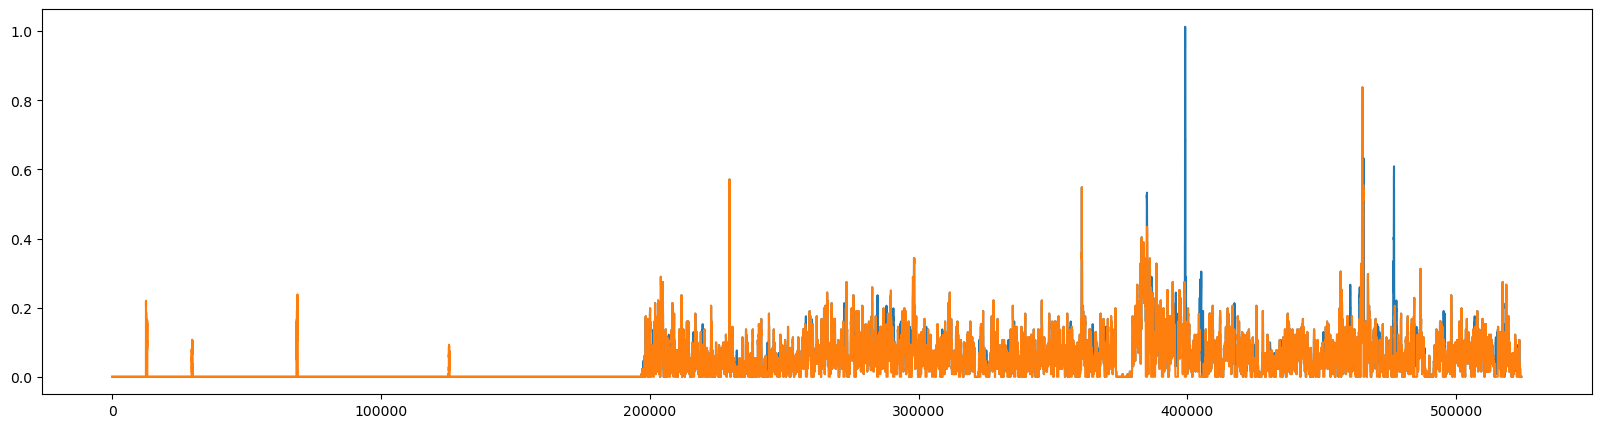

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(out[1][0].numpy(), label='true accessibility')
plt.plot(out_mask[1][0].numpy(), label='masked accessibility')
#this seems more different than it should be...

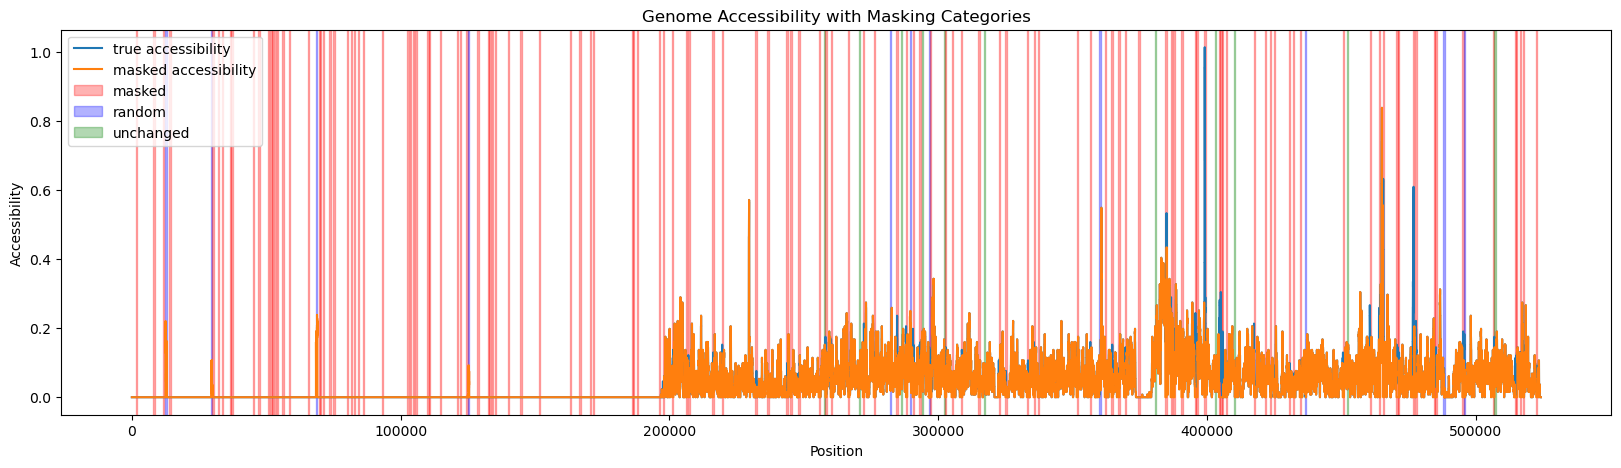

In [49]:
import matplotlib.pyplot as plt
import numpy as np

chunk_size = 500
length = out_mask[1].shape[1]  # assuming out_mask[1] has shape (2, length)
num_chunks = length // chunk_size

# Colors for each category
category_colors = {
    'masked': 'red',       # truly masked (80%)
    'random': 'blue',      # random replacement (10%)
    'unchanged': 'green'   # left unchanged (10%)
}

# Create a base plot with the true and masked accessibility curves.
plt.figure(figsize=(20, 5))
plt.plot(out[1][0].numpy(), label='true accessibility')
plt.plot(out_mask[1][0].numpy(), label='masked accessibility')

# To avoid duplicate legend entries
plotted_categories = set()

# Iterate over chunks
for i in range(num_chunks):
    start = i * chunk_size
    end = start + chunk_size
    
    # Only consider regions where out_mask[3]'s second row is 1 (i.e. evaluation region)
    if torch.all(out_mask[3][1, start:end] == 1):
        true_vals = out_mask[3][0, start:end].numpy()
        masked_vals = out_mask[1][0, start:end].numpy()
        
        # Determine the category:
        if np.allclose(masked_vals, 0):  
            # All values are masked (truly masked)
            category = 'masked'
        elif np.allclose(masked_vals, true_vals):
            # All values unchanged from the true values
            category = 'unchanged'
        else:
            # Some values have been replaced with random values (likely with noise)
            category = 'random'
        
        # Plot a colored vertical span for this chunk
        label = category if category not in plotted_categories else None
        plt.axvspan(start, end, color=category_colors[category], alpha=0.3, label=label)
        plotted_categories.add(category)

plt.legend()
plt.xlabel("Position")
plt.ylabel("Accessibility")
plt.title("Genome Accessibility with Masking Categories")
plt.show()


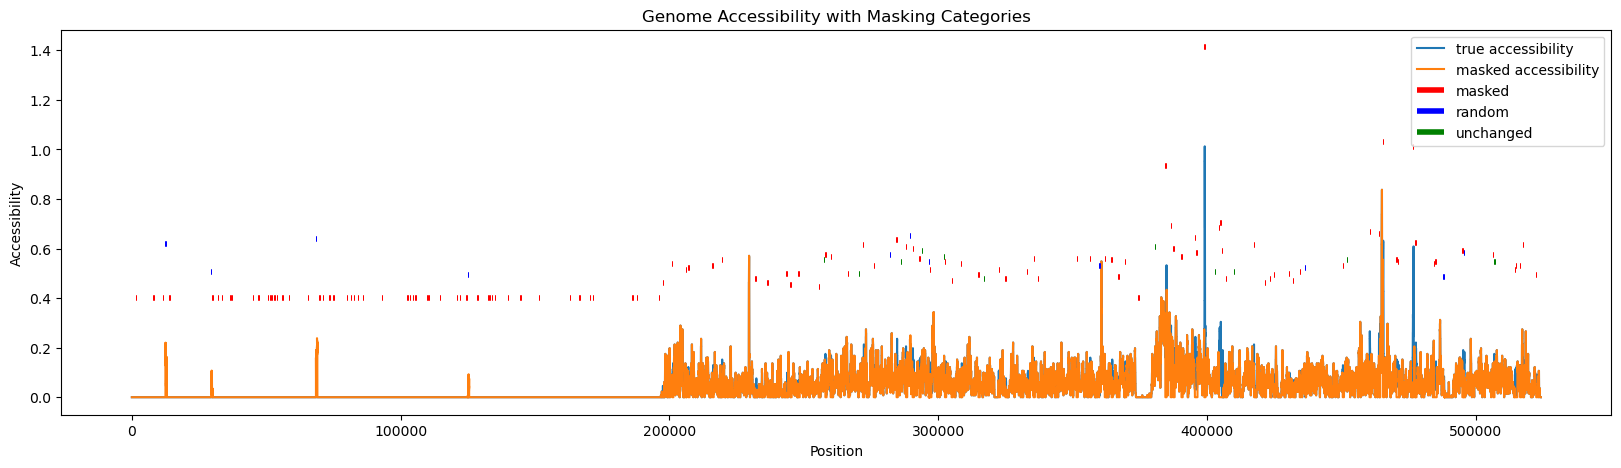

In [53]:
#hmm seems that every value that is different is indeed some noise!
import matplotlib.pyplot as plt
import numpy as np

chunk_size = 500
length = out_mask[1].shape[1]  # assuming out_mask[1] has shape (2, length)
num_chunks = length // chunk_size

# Define colors for each category
category_colors = {
    'masked': 'red',       # truly masked (80%)
    'random': 'blue',      # random replacement (10%)
    'unchanged': 'green'   # unchanged (10%)
}

plt.figure(figsize=(20, 5))
plt.plot(out[1][0].numpy(), label='true accessibility')
plt.plot(out_mask[1][0].numpy(), label='masked accessibility')

# To avoid duplicate legend entries
plotted_categories = set()

# Iterate over chunks
for i in range(num_chunks):
    start = i * chunk_size
    end = start + chunk_size

    # Only consider regions where out_mask[3]'s second row is 1 (evaluation region)
    if torch.all(out_mask[3][1, start:end] == 1):
        true_vals = out_mask[3][0, start:end].numpy()
        masked_vals = out_mask[1][0, start:end].numpy()

        # Determine the category for the chunk:
        if np.allclose(masked_vals, 0):
            category = 'masked'
        elif np.allclose(masked_vals, true_vals):
            category = 'unchanged'
        else:
            category = 'random'

        # Calculate y-value for the horizontal line: max value in chunk plus an offset
        y_line = max(np.max(true_vals), np.max(masked_vals)) + 0.4
        
        # Only add the label once to avoid duplicates in the legend
        label = category if category not in plotted_categories else None
        plt.hlines(y_line, start, end, color=category_colors[category], linewidth=4, label=label)
        plotted_categories.add(category)

plt.legend()
plt.xlabel("Position")
plt.ylabel("Accessibility")
plt.title("Genome Accessibility with Masking Categories")
plt.show()


In [ ]:
#then just manually verify these things
for i in range(out_mask[3].shape[1]):
    if out_mask[3][1,i] == 1:
        continue
    assert out_mask[1][0,i] == out_mask[3][0,i], f"Mismatch at position {i}: {out_mask[1][0,i]} != {out_mask[3][0,i]}"
#for every point that's not the noise we're fine, so this is totally fine!

In [62]:
#let's view this on a different point

for i in range(100):
    out = dataset[i]
    if out[1].max() > 10:
        print(i)

15
19
90


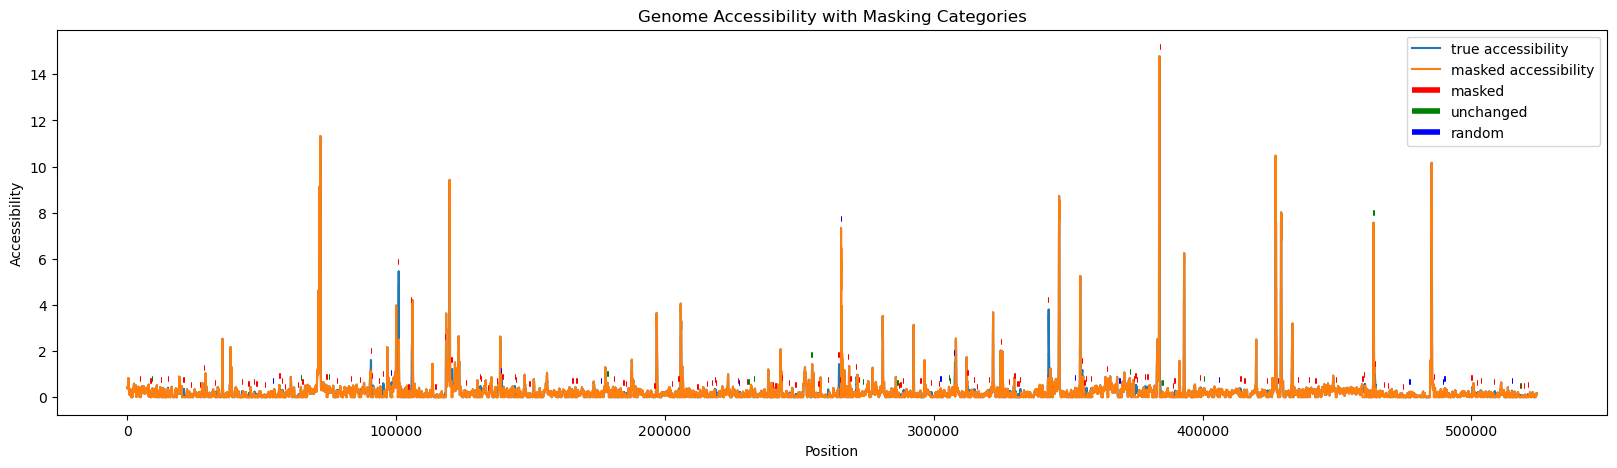

In [66]:
#let's look at 15
out = dataset[15]
out_mask = dataset_mask[15]

chunk_size = 500
length = out_mask[1].shape[1]  # assuming out_mask[1] has shape (2, length)
num_chunks = length // chunk_size

# Define colors for each category
category_colors = {
    'masked': 'red',       # truly masked (80%)
    'random': 'blue',      # random replacement (10%)
    'unchanged': 'green'   # unchanged (10%)
}

plt.figure(figsize=(20, 5))
plt.plot(out[1][0].numpy(), label='true accessibility')
plt.plot(out_mask[1][0].numpy(), label='masked accessibility')

# To avoid duplicate legend entries
plotted_categories = set()

# Iterate over chunks
for i in range(num_chunks):
    start = i * chunk_size
    end = start + chunk_size

    # Only consider regions where out_mask[3]'s second row is 1 (evaluation region)
    if torch.all(out_mask[3][1, start:end] == 1):
        true_vals = out_mask[3][0, start:end].numpy()
        masked_vals = out_mask[1][0, start:end].numpy()

        # Determine the category for the chunk:
        if np.allclose(masked_vals, 0):
            category = 'masked'
        elif np.allclose(masked_vals, true_vals):
            category = 'unchanged'
        else:
            category = 'random'

        # Calculate y-value for the horizontal line: max value in chunk plus an offset
        y_line = max(np.max(true_vals), np.max(masked_vals)) + 0.4
        
        # Only add the label once to avoid duplicates in the legend
        label = category if category not in plotted_categories else None
        plt.hlines(y_line, start, end, color=category_colors[category], linewidth=4, label=label)
        plotted_categories.add(category)

plt.legend()
plt.xlabel("Position")
plt.ylabel("Accessibility")
plt.title("Genome Accessibility with Masking Categories")
plt.show()

#the issue is that 15% is too small, predicts almost all like these 0 values... random almost always ends up being noise too... it would be good to maybe prioritize masking peaks, but oh well, we'll do 25% masking then!

In [64]:
#once again loop thorugh and check
for i in range(out_mask[3].shape[1]):
    if out_mask[3][1,i] == 1:
        continue
    assert out_mask[1][0,i] == out_mask[3][0,i], f"Mismatch at position {i}: {out_mask[1][0,i]} != {out_mask[3][0,i]}"

In [ ]:
#ok and obviously outmask 3 and out1 are the same thing

In [68]:
#now let's reset it and test it on some binned accessibility values and then we can compare, let's see
np.percentile(dataset.data['chr1'],50, axis=1)

array([0.06854248])

In [ ]:
#we made many changes, so we need to test if it works


# final round of testing?

In [69]:
#the main thing we want to test is if our changes and working with categorical values will work
from src.dataloaders.datasets.general_dataset import GeneralDataset
dataset = GeneralDataset(
    split='train',
    preprocess=False,
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
    data_is_zarr=False,
    sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
    length=524288,
    load_in=True
)

dataset_mask = GeneralDataset(
    split='train',
    preprocess=False,
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
    data_is_zarr=False,
    sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
    length=524288,
    load_in=True,
    mlm=0.25,  # increased masking percentage
    acc_mask=0.25,  # increased accessibility masking percentage
)

#let's just test these again quickly

In [70]:
out = dataset[1022]
out_mask = dataset_mask[1022]
for i in range(len(out)):
    print(f'out[{i}] shape: {out[i].shape}')
    print(f'out_mask[{i}] shape: {out_mask[i].shape}')

out[0] shape: torch.Size([5, 524288])
out_mask[0] shape: torch.Size([6, 524288])
out[1] shape: torch.Size([1, 524288])
out_mask[1] shape: torch.Size([2, 524288])
out[2] shape: torch.Size([0])
out_mask[2] shape: torch.Size([6, 524288])
out[3] shape: torch.Size([0])
out_mask[3] shape: torch.Size([2, 524288])


In [71]:
#again manually verify things
for i in range(out_mask[3].shape[1]):
    if out_mask[3][1,i] == 1:
        continue
    assert out_mask[1][0,i] == out_mask[3][0,i], f"Mismatch at position {i}: {out_mask[1][0,i]} != {out_mask[3][0,i]}"

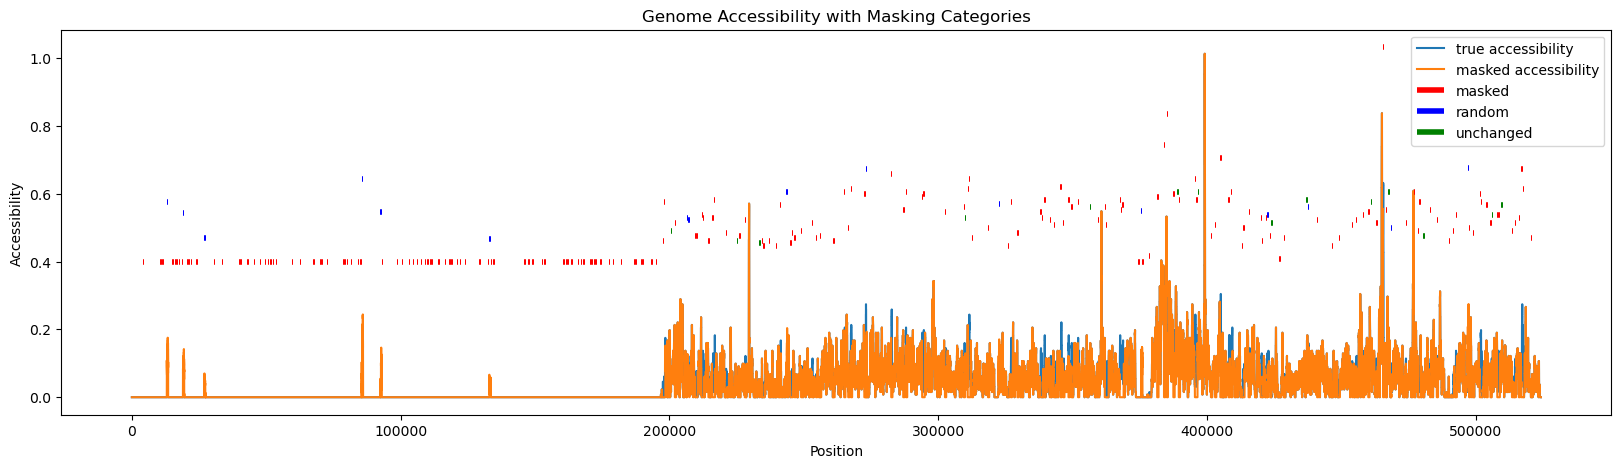

In [72]:
chunk_size = 500
length = out_mask[1].shape[1]  # assuming out_mask[1] has shape (2, length)
num_chunks = length // chunk_size

# Define colors for each category
category_colors = {
    'masked': 'red',       # truly masked (80%)
    'random': 'blue',      # random replacement (10%)
    'unchanged': 'green'   # unchanged (10%)
}

plt.figure(figsize=(20, 5))
plt.plot(out[1][0].numpy(), label='true accessibility')
plt.plot(out_mask[1][0].numpy(), label='masked accessibility')

# To avoid duplicate legend entries
plotted_categories = set()

# Iterate over chunks
for i in range(num_chunks):
    start = i * chunk_size
    end = start + chunk_size

    # Only consider regions where out_mask[3]'s second row is 1 (evaluation region)
    if torch.all(out_mask[3][1, start:end] == 1):
        true_vals = out_mask[3][0, start:end].numpy()
        masked_vals = out_mask[1][0, start:end].numpy()

        # Determine the category for the chunk:
        if np.allclose(masked_vals, 0):
            category = 'masked'
        elif np.allclose(masked_vals, true_vals):
            category = 'unchanged'
        else:
            category = 'random'

        # Calculate y-value for the horizontal line: max value in chunk plus an offset
        y_line = max(np.max(true_vals), np.max(masked_vals)) + 0.4
        
        # Only add the label once to avoid duplicates in the legend
        label = category if category not in plotted_categories else None
        plt.hlines(y_line, start, end, color=category_colors[category], linewidth=4, label=label)
        plotted_categories.add(category)

plt.legend()
plt.xlabel("Position")
plt.ylabel("Accessibility")
plt.title("Genome Accessibility with Masking Categories")
plt.show()

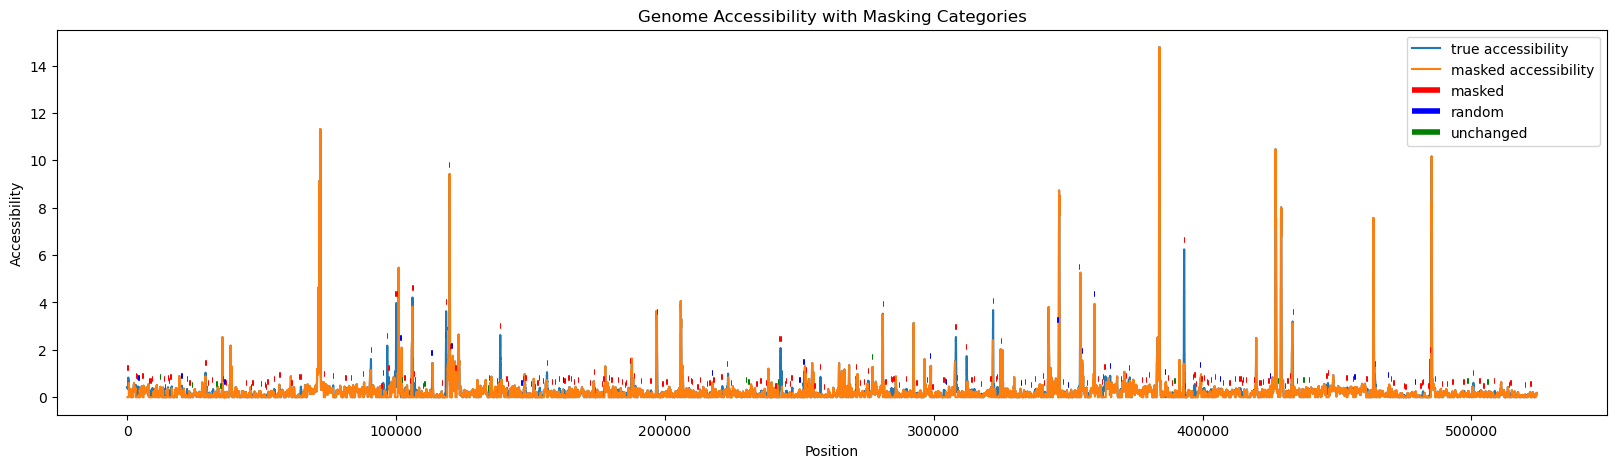

In [73]:
out = dataset[15]
out_mask = dataset_mask[15]

chunk_size = 500
length = out_mask[1].shape[1]  # assuming out_mask[1] has shape (2, length)
num_chunks = length // chunk_size

# Define colors for each category
category_colors = {
    'masked': 'red',       # truly masked (80%)
    'random': 'blue',      # random replacement (10%)
    'unchanged': 'green'   # unchanged (10%)
}

plt.figure(figsize=(20, 5))
plt.plot(out[1][0].numpy(), label='true accessibility')
plt.plot(out_mask[1][0].numpy(), label='masked accessibility')

# To avoid duplicate legend entries
plotted_categories = set()

# Iterate over chunks
for i in range(num_chunks):
    start = i * chunk_size
    end = start + chunk_size

    # Only consider regions where out_mask[3]'s second row is 1 (evaluation region)
    if torch.all(out_mask[3][1, start:end] == 1):
        true_vals = out_mask[3][0, start:end].numpy()
        masked_vals = out_mask[1][0, start:end].numpy()

        # Determine the category for the chunk:
        if np.allclose(masked_vals, 0):
            category = 'masked'
        elif np.allclose(masked_vals, true_vals):
            category = 'unchanged'
        else:
            category = 'random'

        # Calculate y-value for the horizontal line: max value in chunk plus an offset
        y_line = max(np.max(true_vals), np.max(masked_vals)) + 0.4
        
        # Only add the label once to avoid duplicates in the legend
        label = category if category not in plotted_categories else None
        plt.hlines(y_line, start, end, color=category_colors[category], linewidth=4, label=label)
        plotted_categories.add(category)

plt.legend()
plt.xlabel("Position")
plt.ylabel("Accessibility")
plt.title("Genome Accessibility with Masking Categories")
plt.show()

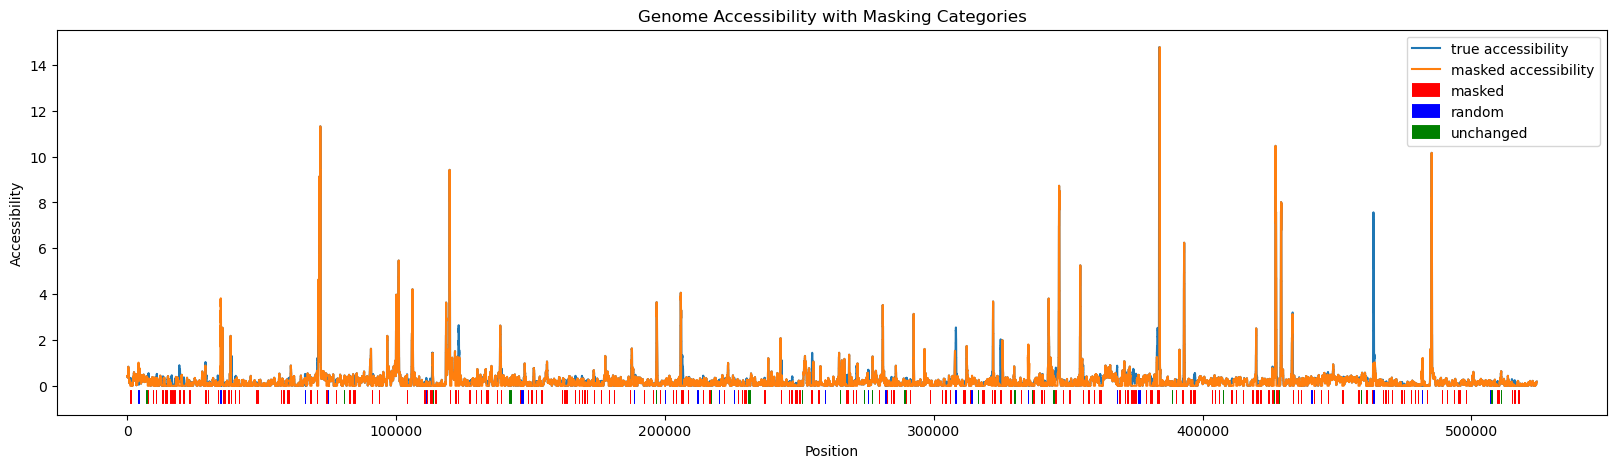

In [81]:
out = dataset[15]
out_mask = dataset_mask[15]

chunk_size = 500
length = out_mask[1].shape[1]  # assuming out_mask[1] has shape (2, length)
num_chunks = length // chunk_size

# Define colors for each category
category_colors = {
    'masked': 'red',       # truly masked (80%)
    'random': 'blue',      # random replacement (10%)
    'unchanged': 'green'   # unchanged (10%)
}

plt.figure(figsize=(20, 5))
plt.plot(out[1][0].numpy(), label='true accessibility')
plt.plot(out_mask[1][0].numpy(), label='masked accessibility')

# To avoid duplicate legend entries
plotted_categories = set()

# Iterate over chunks
for i in range(num_chunks):
    start = i * chunk_size
    end = start + chunk_size

    # Only consider regions where out_mask[3]'s second row is 1 (evaluation region)
    if torch.all(out_mask[3][1, start:end] == 1):
        true_vals = out_mask[3][0, start:end].numpy()
        masked_vals = out_mask[1][0, start:end].numpy()

        # Determine the category for the chunk:
        if np.allclose(masked_vals, 0):
            category = 'masked'
        elif np.allclose(masked_vals, true_vals):
            category = 'unchanged'
        else:
            category = 'random'

        # Calculate y-value for the horizontal line: max value in chunk plus an offset
        # y_line = max(np.max(true_vals), np.max(masked_vals)) + 0.4
        y_line = -0.5
        
        # Only add the label once to avoid duplicates in the legend
        label = category if category not in plotted_categories else None
        plt.hlines(y_line, start, end, color=category_colors[category], linewidth=10, label=label)
        plotted_categories.add(category)

plt.legend()
plt.xlabel("Position")
plt.ylabel("Accessibility")
plt.title("Genome Accessibility with Masking Categories")
plt.show()

In [74]:
torch.allclose(out[1][0], out_mask[3][0]) #so the values are the same, we know this and confirmed it!

True

In [77]:
torch.allclose(out[0], out_mask[2][:-1]) #so the values are the same, we know this and confirmed it!

True

In [85]:
#ok so I think our changes are really fine, 25% is probably too much tho...

#the real test tho, accessibility with categories, if that's working, I think we're good!! 

#let's check other percentiles
np.percentile(dataset.data['chr1'],95, axis=1)

array([0.28173828])

In [ ]:
#we can just set the value at 1. Can also do something to where we weight the peaks more, I implemented that, let's test it too!!

# testing the accessibility categories and peak values

In [1]:
from src.dataloaders.datasets.general_dataset import GeneralDataset
dataset_mask = GeneralDataset(
    split='train',
    preprocess=False,
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
    data_is_zarr=False,
    sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
    length=524288,
    load_in=True,
    mlm=0.25,  # increased masking percentage
    acc_mask=0.25,  # increased accessibility masking percentage
    weight_peaks=True  # weight peaks more (this is the new parameter we added to the dataset class
)

In [2]:
out = dataset_mask[1022]

In [3]:
for i in range(len(out)):
    print(f'out[{i}] shape: {out[i].shape}')

out[0] shape: torch.Size([6, 524288])
out[1] shape: torch.Size([2, 524288])
out[2] shape: torch.Size([6, 524288])
out[3] shape: torch.Size([2, 524288])


In [4]:
dataset = GeneralDataset(
    split='train',
    preprocess=False,
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
    data_is_zarr=False,
    sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
    length=524288,
    load_in=True,
)
out = dataset[1022]
out_mask = dataset_mask[1022]
for i in range(len(out)):
    print(f'out[{i}] shape: {out[i].shape}')
    print(f'out_mask[{i}] shape: {out_mask[i].shape}')

out[0] shape: torch.Size([5, 524288])
out_mask[0] shape: torch.Size([6, 524288])
out[1] shape: torch.Size([1, 524288])
out_mask[1] shape: torch.Size([2, 524288])
out[2] shape: torch.Size([0])
out_mask[2] shape: torch.Size([6, 524288])
out[3] shape: torch.Size([0])
out_mask[3] shape: torch.Size([2, 524288])


In [5]:
#once again check if things are the same
for i in range(out_mask[3].shape[1]):
    if out_mask[3][1,i] == 1:
        continue
    assert out_mask[1][0,i] == out_mask[3][0,i], f"Mismatch at position {i}: {out_mask[1][0,i]} != {out_mask[3][0,i]}"

In [7]:
import torch
print(torch.allclose(out[1][0], out_mask[3][0])) #so the values are the same, we know this and confirmed it!
print(torch.allclose(out[0], out_mask[2][:-1])) #so the values are the same, we know this and confirmed it!

True
True


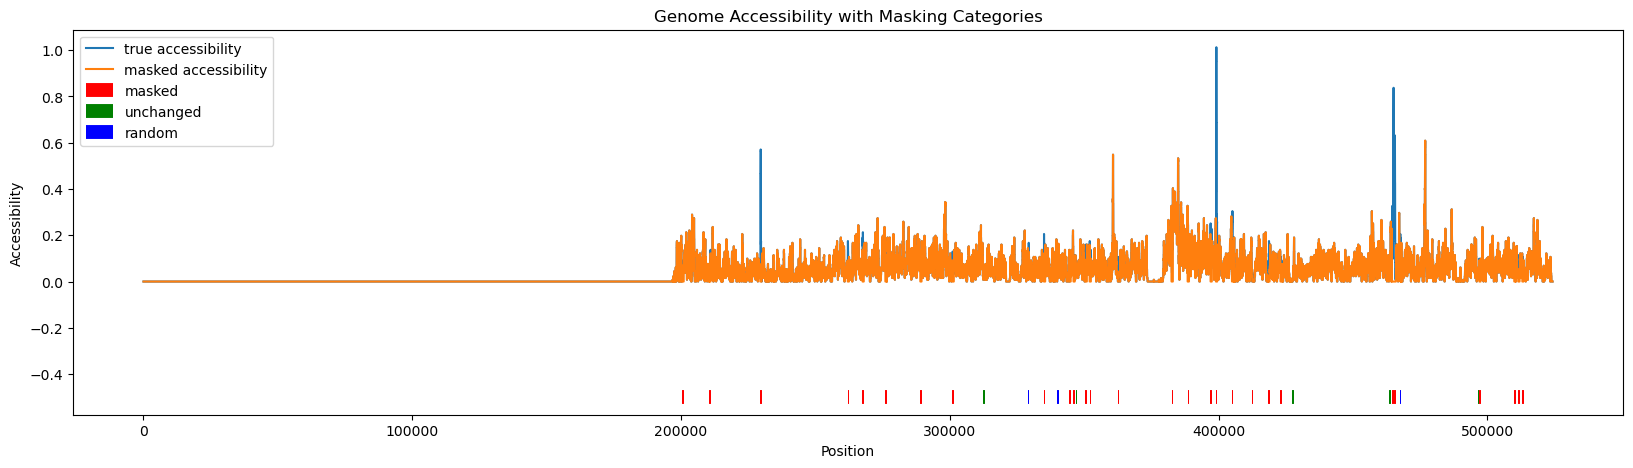

In [ ]:
#ok so I think we might actually be good??
#let's plot it again
import matplotlib.pyplot as plt
import numpy as np
chunk_size = 500
length = out_mask[1].shape[1]  # assuming out_mask[1] has shape (2, length)
num_chunks = length // chunk_size

# Define colors for each category
category_colors = {
    'masked': 'red',       # truly masked (80%)
    'random': 'blue',      # random replacement (10%)
    'unchanged': 'green'   # unchanged (10%)
}

plt.figure(figsize=(20, 5))
plt.plot(out[1][0].numpy(), label='true accessibility')
plt.plot(out_mask[1][0].numpy(), label='masked accessibility')

# To avoid duplicate legend entries
plotted_categories = set()

# Iterate over chunks
for i in range(num_chunks):
    start = i * chunk_size
    end = start + chunk_size

    # Only consider regions where out_mask[3]'s second row is 1 (evaluation region)
    if torch.all(out_mask[3][1, start:end] == 1):
        true_vals = out_mask[3][0, start:end].numpy()
        masked_vals = out_mask[1][0, start:end].numpy()

        # Determine the category for the chunk:
        if np.allclose(masked_vals, 0):
            category = 'masked'
        elif np.allclose(masked_vals, true_vals):
            category = 'unchanged'
        else:
            category = 'random'

        # Calculate y-value for the horizontal line: max value in chunk plus an offset
        # y_line = max(np.max(true_vals), np.max(masked_vals)) + 0.4
        y_line = -0.5
        
        # Only add the label once to avoid duplicates in the legend
        label = category if category not in plotted_categories else None
        plt.hlines(y_line, start, end, color=category_colors[category], linewidth=10, label=label)
        plotted_categories.add(category)

plt.legend()
plt.xlabel("Position")
plt.ylabel("Accessibility")
plt.title("Genome Accessibility with Masking Categories")
plt.show()
#pretty much never access the weird regions anymore

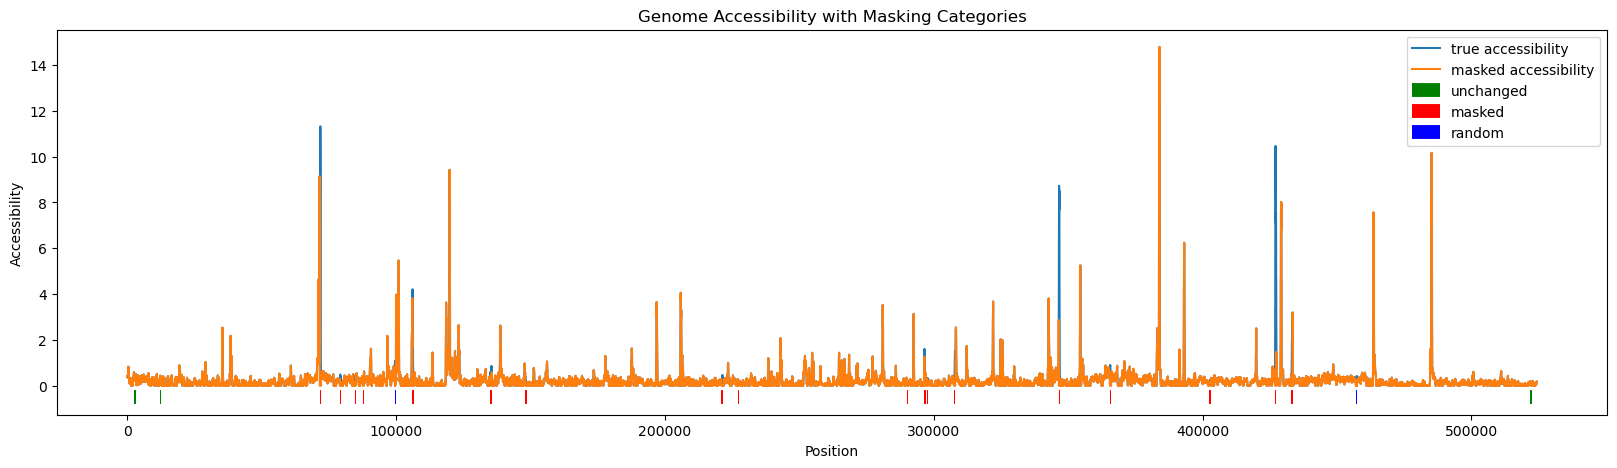

In [11]:
out = dataset[15]
out_mask = dataset_mask[15]

chunk_size = 500
length = out_mask[1].shape[1]  # assuming out_mask[1] has shape (2, length)
num_chunks = length // chunk_size

# Define colors for each category
category_colors = {
    'masked': 'red',       # truly masked (80%)
    'random': 'blue',      # random replacement (10%)
    'unchanged': 'green'   # unchanged (10%)
}

plt.figure(figsize=(20, 5))
plt.plot(out[1][0].numpy(), label='true accessibility')
plt.plot(out_mask[1][0].numpy(), label='masked accessibility')

# To avoid duplicate legend entries
plotted_categories = set()

# Iterate over chunks
for i in range(num_chunks):
    start = i * chunk_size
    end = start + chunk_size

    # Only consider regions where out_mask[3]'s second row is 1 (evaluation region)
    if torch.all(out_mask[3][1, start:end] == 1):
        true_vals = out_mask[3][0, start:end].numpy()
        masked_vals = out_mask[1][0, start:end].numpy()

        # Determine the category for the chunk:
        if np.allclose(masked_vals, 0):
            category = 'masked'
        elif np.allclose(masked_vals, true_vals):
            category = 'unchanged'
        else:
            category = 'random'

        # Calculate y-value for the horizontal line: max value in chunk plus an offset
        # y_line = max(np.max(true_vals), np.max(masked_vals)) + 0.4
        y_line = -0.5
        
        # Only add the label once to avoid duplicates in the legend
        label = category if category not in plotted_categories else None
        plt.hlines(y_line, start, end, color=category_colors[category], linewidth=10, label=label)
        plotted_categories.add(category)

plt.legend()
plt.xlabel("Position")
plt.ylabel("Accessibility")
plt.title("Genome Accessibility with Masking Categories")
plt.show()

In [12]:
#huh we access a lot less regions overall but definitely preferentially peaks, see what percent
out_mask[3].sum(1)

tensor([135825.6875,  11500.0000])

In [ ]:
11500/out_mask[3].shape[1] #so about 2% of the values after weighting it... find a better way to do this

0.02193450927734375

In [20]:
#also make it work on categorical values
dataset_mask = GeneralDataset(
    split='train',
    preprocess=False,
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
    data_is_zarr=False,
    sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
    length=524288,
    load_in=False,
    mlm=0.25,  # increased masking percentage
    acc_mask=0.25,  # increased accessibility masking percentage
    acc_type='category',  # categorical accessibility values
)
out_mask = dataset_mask[1022]

RuntimeError: Tensors must have same number of dimensions: got 3 and 2

In [21]:
#figure this out, unsure why that's 3d for some reason??

#also need to heavily test to make sure the masking makes sense and that things work

#we fix this categorical issue, and finally we have to make sure that still get roughly 15% even when weighting it!

#the 15% was easy, simply scale it up then run clip

chrom,start,stop,split = dataset_mask.sequences.iloc[1022]
print(chrom,start,stop,split)

chr3 10000 141072 train


In [22]:
data = dataset_mask.data[chrom][:,start:stop]
data.shape

(1, 131072)

In [24]:
data = torch.tensor(data)
targets = (data > dataset_mask.acc_threshold).long()
targets = torch.nn.functional.one_hot(targets, num_classes=2).float()
targets.shape

torch.Size([1, 131072, 2])

In [ ]:
#just have to squeeze it!

#fixed it, now let's test it and double check!! let's restart!

In [1]:

#also make it work on categorical values

from src.dataloaders.datasets.general_dataset import GeneralDataset

dataset = GeneralDataset(
    split='train',
    preprocess=False,
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
    data_is_zarr=False,
    sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
    length=524288,
    load_in=False
)

dataset_mask_cont = GeneralDataset(
    split='train',
    preprocess=False,
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
    data_is_zarr=False,
    sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
    length=524288,
    load_in=False,
    mlm=0.25,  # increased masking percentage
    acc_mask=0.25,  # increased accessibility masking percentage
    weight_peaks=True  # weight peaks more (this is the new parameter we added to the dataset class
)

dataset_mask_cat = GeneralDataset(
    split='train',
    preprocess=False,
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
    data_is_zarr=False,
    sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
    length=524288,
    load_in=False,
    mlm=0.25,  # increased masking percentage
    acc_mask=0.25,  # increased accessibility masking percentage
    acc_type='category',  # categorical accessibility values
)

out = dataset[1022]
out_mask_cont = dataset_mask_cont[1022]
out_mask_cat = dataset_mask_cat[1022]

torch.Size([524288, 5])
torch.Size([524288])
torch.Size([524288, 5])
torch.Size([524288, 2])


In [2]:
for i in range(len(out)):
    print(f'out[{i}] shape: {out[i].shape}')
    print(f'out_mask_cont[{i}] shape: {out_mask_cont[i].shape}')
    print(f'out_mask_cat[{i}] shape: {out_mask_cat[i].shape}')

out[0] shape: torch.Size([5, 524288])
out_mask_cont[0] shape: torch.Size([6, 524288])
out_mask_cat[0] shape: torch.Size([6, 524288])
out[1] shape: torch.Size([1, 524288])
out_mask_cont[1] shape: torch.Size([2, 524288])
out_mask_cat[1] shape: torch.Size([3, 524288])
out[2] shape: torch.Size([0])
out_mask_cont[2] shape: torch.Size([6, 524288])
out_mask_cat[2] shape: torch.Size([6, 524288])
out[3] shape: torch.Size([0])
out_mask_cont[3] shape: torch.Size([2, 524288])
out_mask_cat[3] shape: torch.Size([3, 524288])


In [3]:
#now let's compare the 15% thing
out_mask_cont[3].sum(1)

tensor([ 23360.5254, 139500.0000])

In [ ]:
140000/524288 #around 25% which is what we asked for!

0.26702880859375

torch.Size([524288, 5])
torch.Size([524288])


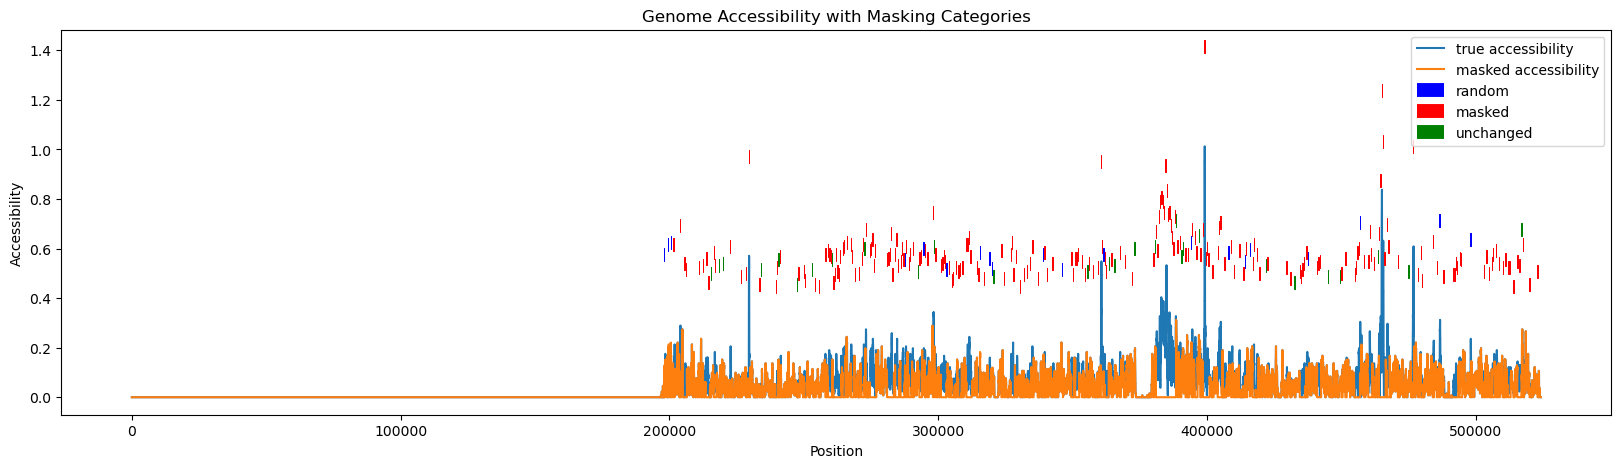

In [9]:
import matplotlib.pyplot as plt
import torch
import numpy as np
out = dataset[1022]
out_mask = dataset_mask_cont[1022]

chunk_size = 500
length = out_mask[1].shape[1]  # assuming out_mask[1] has shape (2, length)
num_chunks = length // chunk_size

# Define colors for each category
category_colors = {
    'masked': 'red',       # truly masked (80%)
    'random': 'blue',      # random replacement (10%)
    'unchanged': 'green'   # unchanged (10%)
}

plt.figure(figsize=(20, 5))
plt.plot(out[1][0].numpy(), label='true accessibility')
plt.plot(out_mask[1][0].numpy(), label='masked accessibility')

# To avoid duplicate legend entries
plotted_categories = set()

# Iterate over chunks
for i in range(num_chunks):
    start = i * chunk_size
    end = start + chunk_size

    # Only consider regions where out_mask[3]'s second row is 1 (evaluation region)
    if torch.all(out_mask[3][1, start:end] == 1):
        true_vals = out_mask[3][0, start:end].numpy()
        masked_vals = out_mask[1][0, start:end].numpy()

        # Determine the category for the chunk:
        if np.allclose(masked_vals, 0):
            category = 'masked'
        elif np.allclose(masked_vals, true_vals):
            category = 'unchanged'
        else:
            category = 'random'

        # Calculate y-value for the horizontal line: max value in chunk plus an offset
        y_line = max(np.max(true_vals), np.max(masked_vals)) + 0.4
        # y_line = -0.5
        
        # Only add the label once to avoid duplicates in the legend
        label = category if category not in plotted_categories else None
        plt.hlines(y_line, start, end, color=category_colors[category], linewidth=10, label=label)
        plotted_categories.add(category)

plt.legend()
plt.xlabel("Position")
plt.ylabel("Accessibility")
plt.title("Genome Accessibility with Masking Categories")
plt.show()

torch.Size([524288, 5])
torch.Size([524288])


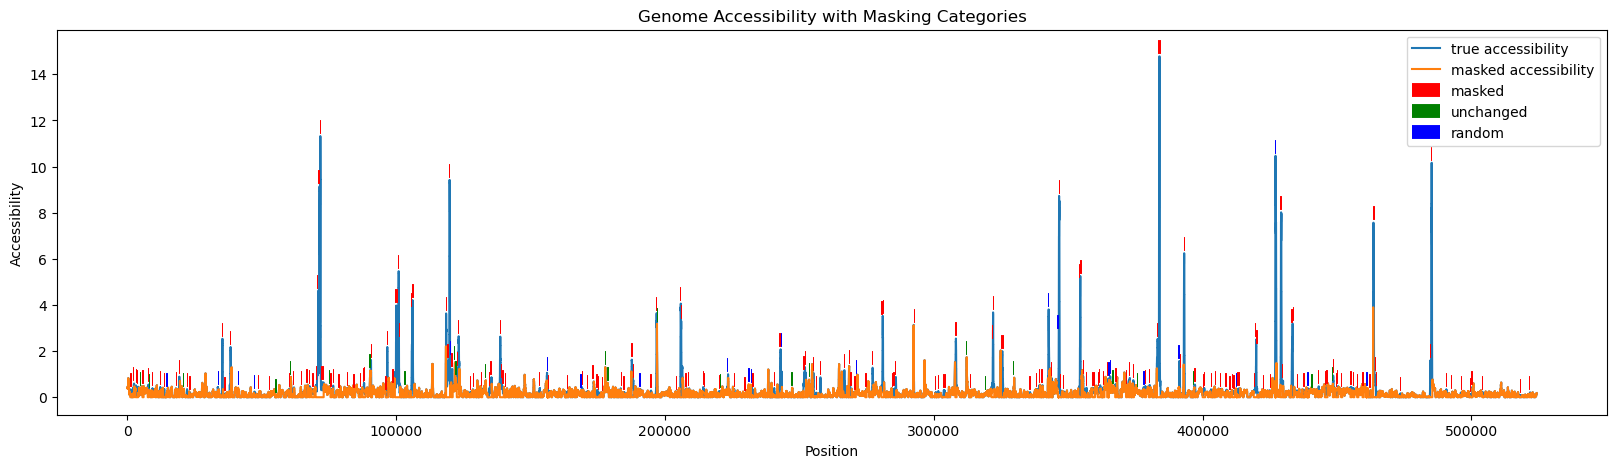

In [11]:
#let's check region 15
out = dataset[15]
out_mask = dataset_mask_cont[15]

chunk_size = 500
length = out_mask[1].shape[1]  # assuming out_mask[1] has shape (2, length)
num_chunks = length // chunk_size

# Define colors for each category
category_colors = {
    'masked': 'red',       # truly masked (80%)
    'random': 'blue',      # random replacement (10%)
    'unchanged': 'green'   # unchanged (10%)
}

plt.figure(figsize=(20, 5))
plt.plot(out[1][0].numpy(), label='true accessibility')
plt.plot(out_mask[1][0].numpy(), label='masked accessibility')

# To avoid duplicate legend entries
plotted_categories = set()

# Iterate over chunks
for i in range(num_chunks):
    start = i * chunk_size
    end = start + chunk_size

    # Only consider regions where out_mask[3]'s second row is 1 (evaluation region)
    if torch.all(out_mask[3][1, start:end] == 1):
        true_vals = out_mask[3][0, start:end].numpy()
        masked_vals = out_mask[1][0, start:end].numpy()

        # Determine the category for the chunk:
        if np.allclose(masked_vals, 0):
            category = 'masked'
        elif np.allclose(masked_vals, true_vals):
            category = 'unchanged'
        else:
            category = 'random'

        # Calculate y-value for the horizontal line: max value in chunk plus an offset
        y_line = max(np.max(true_vals), np.max(masked_vals)) + 0.4
        # y_line = -0.5
        
        # Only add the label once to avoid duplicates in the legend
        label = category if category not in plotted_categories else None
        plt.hlines(y_line, start, end, color=category_colors[category], linewidth=10, label=label)
        plotted_categories.add(category)

plt.legend()
plt.xlabel("Position")
plt.ylabel("Accessibility")
plt.title("Genome Accessibility with Masking Categories")
plt.show()

In [ ]:
#very preferentially masks peaks and masks almost all of them but it's fine I guess??
#Maybe the weighting is too much but that's the comparison!! This is really cool overall tho, I think we got it!! 

#the key things are again just test to see if the masking is correct, test it!!

torch.Size([524288, 5])
torch.Size([524288, 2])


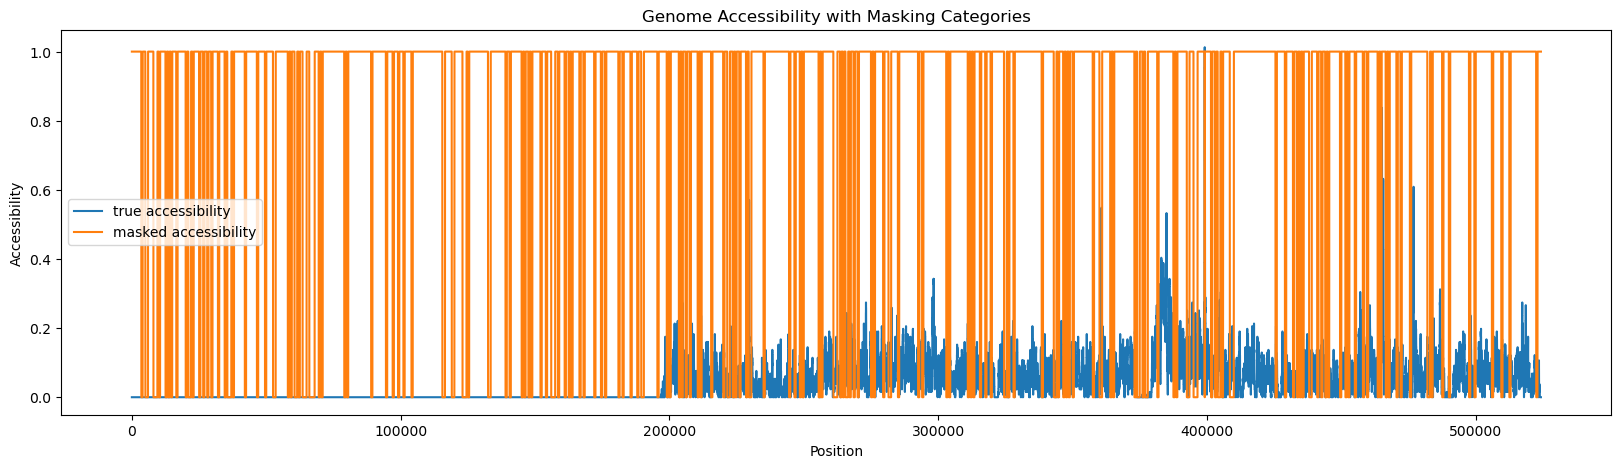

In [10]:
#potentially 25% is too much, and still too biased towards regions with higher values, but this is overall probably better?
#there's better ways to weight it!

import matplotlib.pyplot as plt
import torch
import numpy as np
out = dataset[1022]
out_mask = dataset_mask_cat[1022]

chunk_size = 500
length = out_mask[1].shape[1]  # assuming out_mask[1] has shape (2, length)
num_chunks = length // chunk_size

# Define colors for each category
category_colors = {
    'masked': 'red',       # truly masked (80%)
    'random': 'blue',      # random replacement (10%)
    'unchanged': 'green'   # unchanged (10%)
}

plt.figure(figsize=(20, 5))
plt.plot(out[1][0].numpy(), label='true accessibility')
plt.plot(out_mask[1][0].numpy(), label='masked accessibility')

# To avoid duplicate legend entries
plotted_categories = set()

# Iterate over chunks
for i in range(num_chunks):
    start = i * chunk_size
    end = start + chunk_size

    # Only consider regions where out_mask[3]'s second row is 1 (evaluation region)
    if torch.all(out_mask[3][1, start:end] == 1):
        true_vals = out_mask[3][0, start:end].numpy()
        masked_vals = out_mask[1][0, start:end].numpy()

        # Determine the category for the chunk:
        if np.allclose(masked_vals, 0):
            category = 'masked'
        elif np.allclose(masked_vals, true_vals):
            category = 'unchanged'
        else:
            category = 'random'

        # Calculate y-value for the horizontal line: max value in chunk plus an offset
        y_line = max(np.max(true_vals), np.max(masked_vals)) + 0.4
        # y_line = -0.5
        
        # Only add the label once to avoid duplicates in the legend
        label = category if category not in plotted_categories else None
        plt.hlines(y_line, start, end, color=category_colors[category], linewidth=10, label=label)
        plotted_categories.add(category)

plt.legend()
plt.xlabel("Position")
plt.ylabel("Accessibility")
plt.title("Genome Accessibility with Masking Categories")
plt.show()

In [ ]:
#need to make better visualizationss, and to also test if this cateogircal thing makes any sense!!



# full testing of my datasets, make sure this makes sense, and verify that it works as we expect!!

In [1]:
#we will first test a non padded region (15) and verify that it works and pads as we think it should!
#if this works, then we are done with the padding!! 
#only thing this lacks is the ability to generalize across tracks. Could for loop it, but surely there's an easy way, especially if sharing the masking? but maybe ideal not to shar emasking?

from src.dataloaders.datasets.general_dataset import GeneralDataset
import torch
import numpy as np
import matplotlib.pyplot as plt

dataset = GeneralDataset(
    split='train',
    preprocess=False,
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
    data_is_zarr=False,
    sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
    length=524288,
    load_in=False
)

dataset_mask_cont = GeneralDataset(
    split='train',
    preprocess=False,
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
    data_is_zarr=False,
    sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
    length=524288,
    load_in=False,
    mlm=0.25,  # increased masking percentage
    acc_mask=0.25,  # increased accessibility masking percentage
    weight_peaks=True  # weight peaks more (this is the new parameter we added to the dataset class
)

dataset_mask_cat = GeneralDataset(
    split='train',
    preprocess=False,
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
    data_is_zarr=False,
    sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
    length=524288,
    load_in=False,
    mlm=0.25,  # increased masking percentage
    acc_mask=0.25,  # increased accessibility masking percentage
    acc_type='category',  # categorical accessibility values
)

out = dataset[15]
out_mask_cont = dataset_mask_cont[15]
out_mask_cat = dataset_mask_cat[15]

In [2]:
for i in range(len(out)):
    print(f'output_{i}', out[i].shape, out_mask_cont[i].shape, out_mask_cat[i].shape)

output_0 torch.Size([5, 524288]) torch.Size([6, 524288]) torch.Size([6, 524288])
output_1 torch.Size([1, 524288]) torch.Size([2, 524288]) torch.Size([3, 524288])
output_2 torch.Size([0]) torch.Size([6, 524288]) torch.Size([6, 524288])
output_3 torch.Size([0]) torch.Size([2, 524288]) torch.Size([3, 524288])


In [ ]:
#first let's test the continuous masking
print(torch.allclose(out[0], out_mask_cont[2][:-1]))  # should be True since it's the sequence then jsut says random ones ar masked
print(torch.allclose(out[1], out_mask_cont[3][:-1]))  # should be True since it's the sequence then jsut says random ones ar masked
#it is indeed, so it works here

True
True


In [4]:
#so we do indeed have the original data, now lets' check the mask to make sure it makes sense

out_mask_cont[2]

tensor([[1., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 1.]])

In [5]:
out_mask_cont[0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 1.]])

In [22]:
out_mask_cont[0].sum(1) 

tensor([ 99387., 112693., 110860.,  96770.,      0., 104578.])

In [ ]:
104578/524288 #so about 20% of the values are masked, which is a little bit lower than the 25 because excludes the ones that are changed or just will be evaluated

0.19946670532226562

In [25]:
out_mask_cont[2].sum(1)

tensor([124017., 141318., 138681., 120272.,      0., 130723.])

In [ ]:
130723/524288 #so about 25% of the values are masked, which is what we would normallyy exxpect

0.24933433532714844

In [ ]:
#so now let's just look at some random strings and see!
start=1600
print(out_mask_cont[0][:,start:start+18])
print()
print(out_mask_cont[2][:,start:start+18])
#here we see an exxample of ranodm replacement, but where it isn't replaced it's fine1

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.]])

tensor([[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.]])


In [ ]:
#loop over the elements to verify
for i in range(out_mask_cont[3].shape[1]):
    if out_mask_cont[3][1,i] == 1: #indicates masked, whether masked or changed or unchanged, don't know, so skip
        continue
    assert torch.allclose(out_mask_cont[1][:,i], out_mask_cont[3][:,i]), f"Mismatch at position {i}: {out_mask_cont[1][0,i]} != {out_mask_cont[3][0,i]}"
#never run into issues, so we can assume that it's actualllly fine, we did verify this several times, always identical except when 

In [ ]:
#so let's say that the masking for the sequence is correct, now let's check the continuous values
print(out_mask_cont[1].sum(1)) #18% ish
print(out_mask_cont[3].sum(1)) #123000, is 23% so pretty close, not bad at all!! 

tensor([71899.3906, 98000.0000])
tensor([135825.6875, 123000.0000])


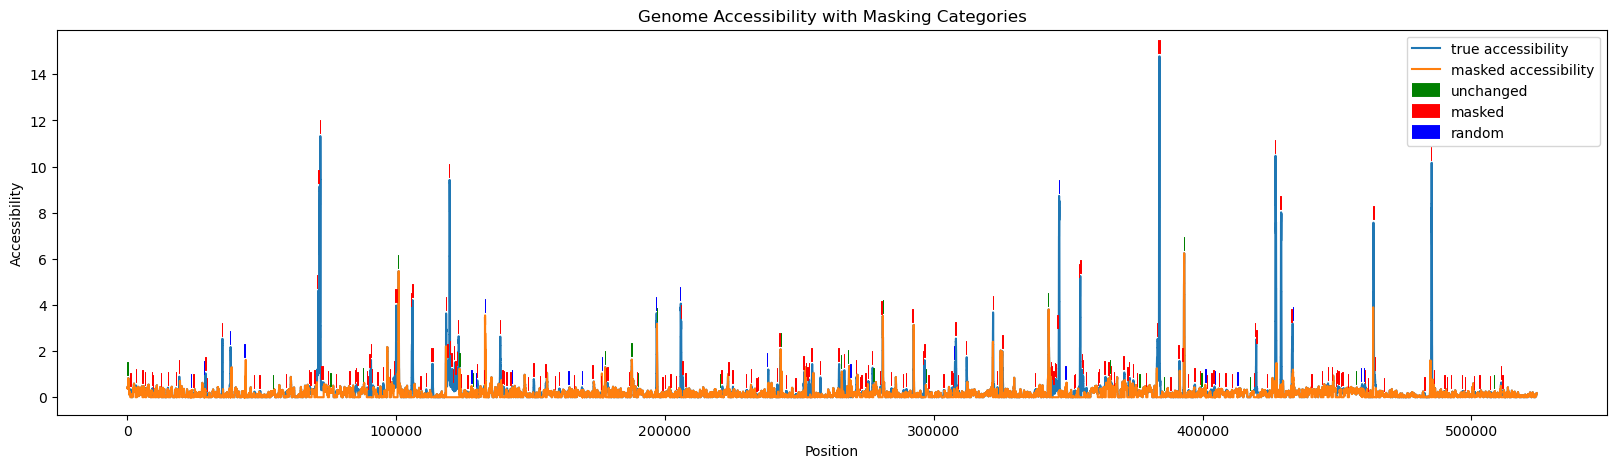

In [28]:
#now let's plot it to get a visualization

out = dataset[15]
out_mask = dataset_mask_cont[15]

chunk_size = 500
length = out_mask[1].shape[1]  # assuming out_mask[1] has shape (2, length)
num_chunks = length // chunk_size

# Define colors for each category
category_colors = {
    'masked': 'red',       # truly masked (80%)
    'random': 'blue',      # random replacement (10%)
    'unchanged': 'green'   # unchanged (10%)
}

plt.figure(figsize=(20, 5))
plt.plot(out[1][0].numpy(), label='true accessibility')
plt.plot(out_mask[1][0].numpy(), label='masked accessibility')

# To avoid duplicate legend entries
plotted_categories = set()

# Iterate over chunks
for i in range(num_chunks):
    start = i * chunk_size
    end = start + chunk_size

    # Only consider regions where out_mask[3]'s second row is 1 (evaluation region)
    if torch.all(out_mask[3][1, start:end] == 1):
        true_vals = out_mask[3][0, start:end].numpy()
        masked_vals = out_mask[1][0, start:end].numpy()

        # Determine the category for the chunk:
        if np.allclose(masked_vals, 0):
            category = 'masked'
        elif np.allclose(masked_vals, true_vals):
            category = 'unchanged'
        else:
            category = 'random'

        # Calculate y-value for the horizontal line: max value in chunk plus an offset
        y_line = max(np.max(true_vals), np.max(masked_vals)) + 0.4
        # y_line = -0.5
        
        # Only add the label once to avoid duplicates in the legend
        label = category if category not in plotted_categories else None
        plt.hlines(y_line, start, end, color=category_colors[category], linewidth=10, label=label)
        plotted_categories.add(category)

plt.legend()
plt.xlabel("Position")
plt.ylabel("Accessibility")
plt.title("Genome Accessibility with Masking Categories")
plt.show()

In [ ]:
#we've seen this before, almost always prefers the peaks, but sometimes not always? so mayybe it still learns something cool? idk actually...
#now let's verify that the values make sense
start= 1600
print(out_mask[1][:,start:start+9]) #here mask is 0 so no changes
print(out_mask[3][:,start:start+9])

tensor([[0.0685, 0.0685, 0.0685, 0.0685, 0.0685, 0.0685, 0.0685, 0.0685, 0.0685],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
tensor([[0.0685, 0.0685, 0.0685, 0.0685, 0.0685, 0.0685, 0.0685, 0.0685, 0.0685],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


In [42]:
start = 995
#can only transition over every 500 elements because it's this strict type masking, this is potentially a big problem, but oh well?
#here is a true mask.
#as long as the sequences we sample aren't the same everytime like using enformer's sequences.bed it will be fine
#we might use it anyways, but the point is just get an idea of what this training regime does. Maybe learns artificial noisy boundaries, so can vary the length of 500 or sample randomly from the genome?
#so we added in the dataset some slight shifts, this means can randomly shift, so won't be identical for testing, but a very simple feature to implement!
print(out_mask[1][:,start:start+9]) #here mask is 0 so no changes
print(out_mask[3][:,start:start+9])

tensor([[0.0837, 0.0837, 0.0837, 0.0837, 0.0837, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000]])
tensor([[0.0837, 0.0837, 0.0837, 0.0837, 0.0837, 0.0837, 0.0837, 0.0837, 0.0837],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000]])


In [ ]:
#let's make sure that it's not only supposed to predict 0.837
print(out_mask[3][:,start:start+90]) #here mask is 0 so no changes

#yes it does shift over!! this means not predicting the number only on the sides but can change!

tensor([[0.0837, 0.0837, 0.0837, 0.0837, 0.0837, 0.0837, 0.0837, 0.0837, 0.0837,
         0.0837, 0.0837, 0.0837, 0.0837, 0.0837, 0.0837, 0.0837, 0.1142, 0.1142,
         0.1142, 0.1142, 0.1142, 0.1142, 0.1142, 0.1142, 0.1142, 0.1142, 0.1142,
         0.1142, 0.1142, 0.1142, 0.1142, 0.1142, 0.1142, 0.1142, 0.1142, 0.1142,
         0.1066, 0.1066, 0.1066, 0.1066, 0.1066, 0.1066, 0.1066, 0.1066, 0.1066,
         0.1066, 0.1066, 0.1066, 0.1066, 0.1066, 0.1066, 0.1066, 0.1066, 0.1066,
         0.1066, 0.1066, 0.1522, 0.1522, 0.1522, 0.1522, 0.1522, 0.1522, 0.1522,
         0.1522, 0.1522, 0.1522, 0.1522, 0.1522, 0.1522, 0.1522, 0.1522, 0.1522,
         0.1522, 0.1522, 0.1522, 0.1522, 0.1142, 0.1142, 0.1142, 0.1142, 0.1142,
         0.1142, 0.1142, 0.1142, 0.1142, 0.1142, 0.1142, 0.1142, 0.1142, 0.1142],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.

In [46]:
#let's look within a peak and see how long the peak actually is
#find the value that is above 14
out_mask[3].max(1)

torch.return_types.max(
values=tensor([14.7734,  1.0000]),
indices=tensor([383851,      0]))

In [48]:
start = 383851-5
print(out_mask[3][:,start:start+90]) #here mask is 0 so no changes
#so we see that it is indeed a peak, but the values are all over the place, so maybe it's not learning anything useful?

tensor([[ 9.3672,  9.3672,  9.3672,  9.3672,  9.3672, 14.7734, 14.7734, 14.7734,
         14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734,
         14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734,
         14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734,
         14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734,
         14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734,
         14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734,
         14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734,
         14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734,
         14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734,
         14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734, 14.7734,
         14.7734, 14.7734],
        [ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,


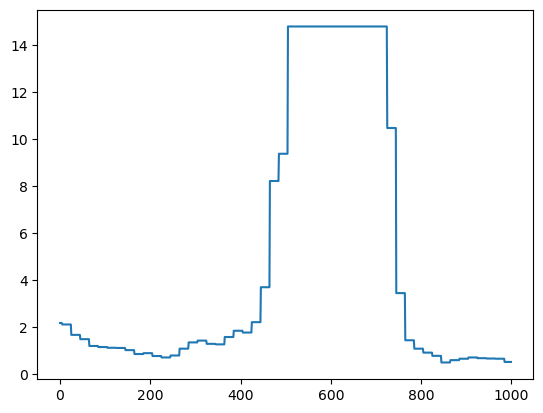

In [ ]:
plt.plot(out_mask[3][0,start-500:start+500].numpy())
#the peak itself is actually reasonably thin

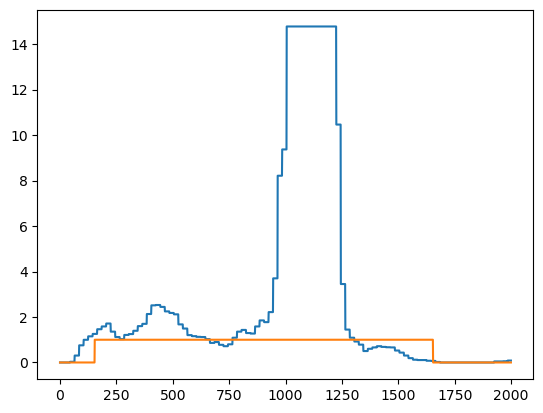

In [54]:
#and let's see where the mask is
plt.plot(out_mask[3][0,start-1000:start+1000].numpy())
plt.plot(out_mask[3][1,start-1000:start+1000].numpy())
#this whole area is masked out...

In [ ]:
#ahh because continuous masking since we weighted it, yeah so weighting it means has to predict like this whole thing which is hard of course...
#I think we're biased too much towards masked regions, let's reset it and check it again, reduce the effect that weighting has
#now instead of log which even for 14 is quite large, we used min maxx scaling and changed range to 1-2 so maxx values weight twice as much!

In [1]:
#let's see what this looks like, restart again
from src.dataloaders.datasets.general_dataset import GeneralDataset
import torch
import numpy as np
import matplotlib.pyplot as plt

dataset = GeneralDataset(
    split='train',
    preprocess=False,
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
    data_is_zarr=False,
    sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
    length=524288,
    load_in=False
)

dataset_mask_cont = GeneralDataset(
    split='train',
    preprocess=False,
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
    data_is_zarr=False,
    sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
    length=524288,
    load_in=False,
    mlm=0.25,  # increased masking percentage
    acc_mask=0.25,  # increased accessibility masking percentage
    weight_peaks=True  # weight peaks more (this is the new parameter we added to the dataset class
)

dataset_mask_cat = GeneralDataset(
    split='train',
    preprocess=False,
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
    data_is_zarr=False,
    sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
    length=524288,
    load_in=False,
    mlm=0.25,  # increased masking percentage
    acc_mask=0.25,  # increased accessibility masking percentage
    acc_type='category',  # categorical accessibility values
)

out = dataset[15]
out_mask_cont = dataset_mask_cont[15]
out_mask_cat = dataset_mask_cat[15]

In [2]:
out_mask = dataset_mask_cont[15]

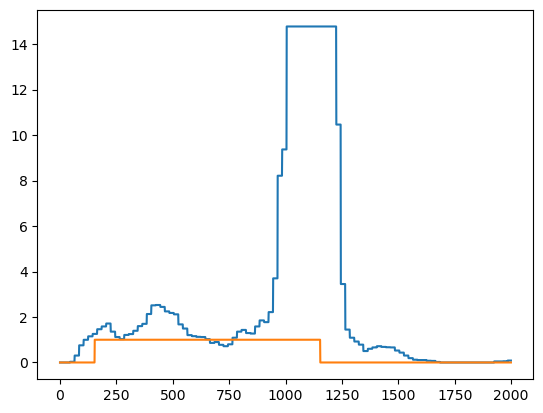

In [4]:
start = 383851-5
plt.plot(out_mask[3][0,start-1000:start+1000].numpy())
plt.plot(out_mask[3][1,start-1000:start+1000].numpy())

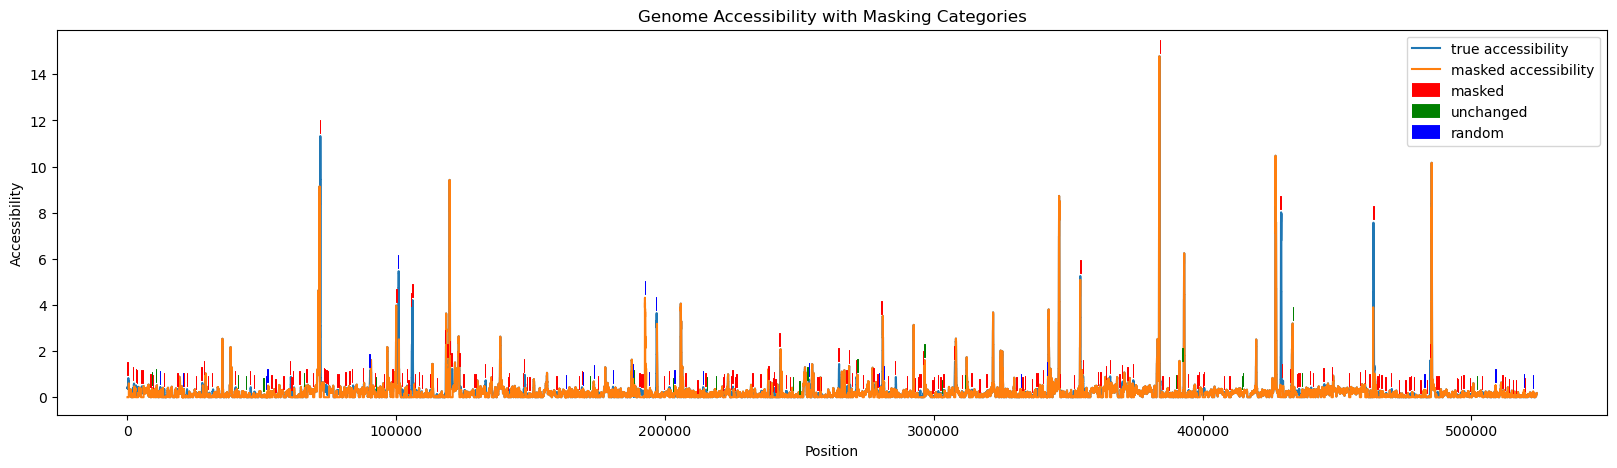

In [5]:
#and let's look at the full plot
out = dataset[15]
out_mask = dataset_mask_cont[15]

chunk_size = 500
length = out_mask[1].shape[1]  # assuming out_mask[1] has shape (2, length)
num_chunks = length // chunk_size

# Define colors for each category
category_colors = {
    'masked': 'red',       # truly masked (80%)
    'random': 'blue',      # random replacement (10%)
    'unchanged': 'green'   # unchanged (10%)
}

plt.figure(figsize=(20, 5))
plt.plot(out[1][0].numpy(), label='true accessibility')
plt.plot(out_mask[1][0].numpy(), label='masked accessibility')

# To avoid duplicate legend entries
plotted_categories = set()

# Iterate over chunks
for i in range(num_chunks):
    start = i * chunk_size
    end = start + chunk_size

    # Only consider regions where out_mask[3]'s second row is 1 (evaluation region)
    if torch.all(out_mask[3][1, start:end] == 1):
        true_vals = out_mask[3][0, start:end].numpy()
        masked_vals = out_mask[1][0, start:end].numpy()

        # Determine the category for the chunk:
        if np.allclose(masked_vals, 0):
            category = 'masked'
        elif np.allclose(masked_vals, true_vals):
            category = 'unchanged'
        else:
            category = 'random'

        # Calculate y-value for the horizontal line: max value in chunk plus an offset
        y_line = max(np.max(true_vals), np.max(masked_vals)) + 0.4
        # y_line = -0.5
        
        # Only add the label once to avoid duplicates in the legend
        label = category if category not in plotted_categories else None
        plt.hlines(y_line, start, end, color=category_colors[category], linewidth=10, label=label)
        plotted_categories.add(category)

plt.legend()
plt.xlabel("Position")
plt.ylabel("Accessibility")
plt.title("Genome Accessibility with Masking Categories")
plt.show()

In [1]:
#I think we prefer this? maybe weight to peaks just a bit higher?
#so I changed the scaling, let's check it again

#let's see what this looks like, restart again
from src.dataloaders.datasets.general_dataset import GeneralDataset
import torch
import numpy as np
import matplotlib.pyplot as plt

dataset = GeneralDataset(
    split='train',
    preprocess=False,
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
    data_is_zarr=False,
    sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
    length=524288,
    load_in=False
)

dataset_mask_cont = GeneralDataset(
    split='train',
    preprocess=False,
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
    data_is_zarr=False,
    sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
    length=524288,
    load_in=False,
    mlm=0.25,  # increased masking percentage
    acc_mask=0.25,  # increased accessibility masking percentage
    weight_peaks=True  # weight peaks more (this is the new parameter we added to the dataset class
)

dataset_mask_cat = GeneralDataset(
    split='train',
    preprocess=False,
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
    data_is_zarr=False,
    sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
    length=524288,
    load_in=False,
    mlm=0.25,  # increased masking percentage
    acc_mask=0.25,  # increased accessibility masking percentage
    acc_type='category',  # categorical accessibility values
)

out = dataset[15]
out_mask_cont = dataset_mask_cont[15]
out_mask_cat = dataset_mask_cat[15]

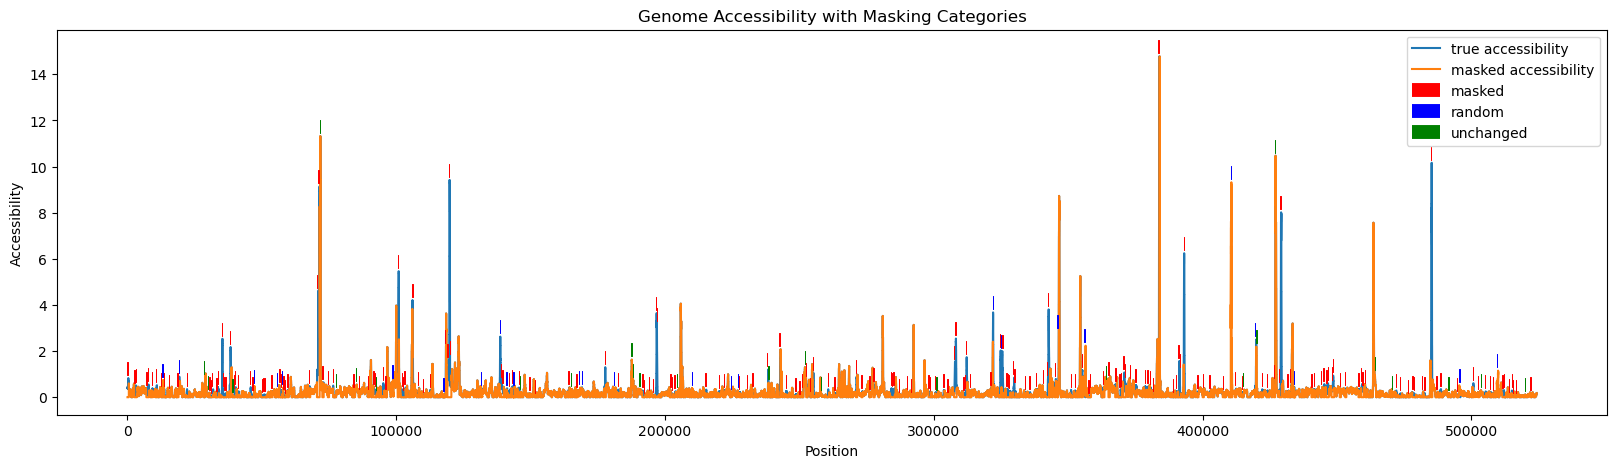

In [2]:
#and let's look at the full plot
out = dataset[15]
out_mask = dataset_mask_cont[15]

chunk_size = 500
length = out_mask[1].shape[1]  # assuming out_mask[1] has shape (2, length)
num_chunks = length // chunk_size

# Define colors for each category
category_colors = {
    'masked': 'red',       # truly masked (80%)
    'random': 'blue',      # random replacement (10%)
    'unchanged': 'green'   # unchanged (10%)
}

plt.figure(figsize=(20, 5))
plt.plot(out[1][0].numpy(), label='true accessibility')
plt.plot(out_mask[1][0].numpy(), label='masked accessibility')

# To avoid duplicate legend entries
plotted_categories = set()

# Iterate over chunks
for i in range(num_chunks):
    start = i * chunk_size
    end = start + chunk_size

    # Only consider regions where out_mask[3]'s second row is 1 (evaluation region)
    if torch.all(out_mask[3][1, start:end] == 1):
        true_vals = out_mask[3][0, start:end].numpy()
        masked_vals = out_mask[1][0, start:end].numpy()

        # Determine the category for the chunk:
        if np.allclose(masked_vals, 0):
            category = 'masked'
        elif np.allclose(masked_vals, true_vals):
            category = 'unchanged'
        else:
            category = 'random'

        # Calculate y-value for the horizontal line: max value in chunk plus an offset
        y_line = max(np.max(true_vals), np.max(masked_vals)) + 0.4
        # y_line = -0.5
        
        # Only add the label once to avoid duplicates in the legend
        label = category if category not in plotted_categories else None
        plt.hlines(y_line, start, end, color=category_colors[category], linewidth=10, label=label)
        plotted_categories.add(category)

plt.legend()
plt.xlabel("Position")
plt.ylabel("Accessibility")
plt.title("Genome Accessibility with Masking Categories")
plt.show()

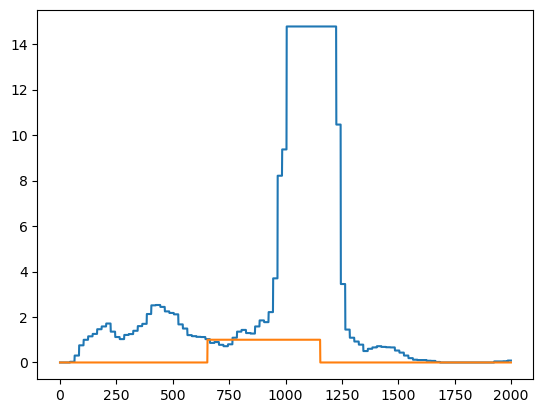

In [3]:
start = 383851-5
plt.plot(out_mask[3][0,start-1000:start+1000].numpy())
plt.plot(out_mask[3][1,start-1000:start+1000].numpy())

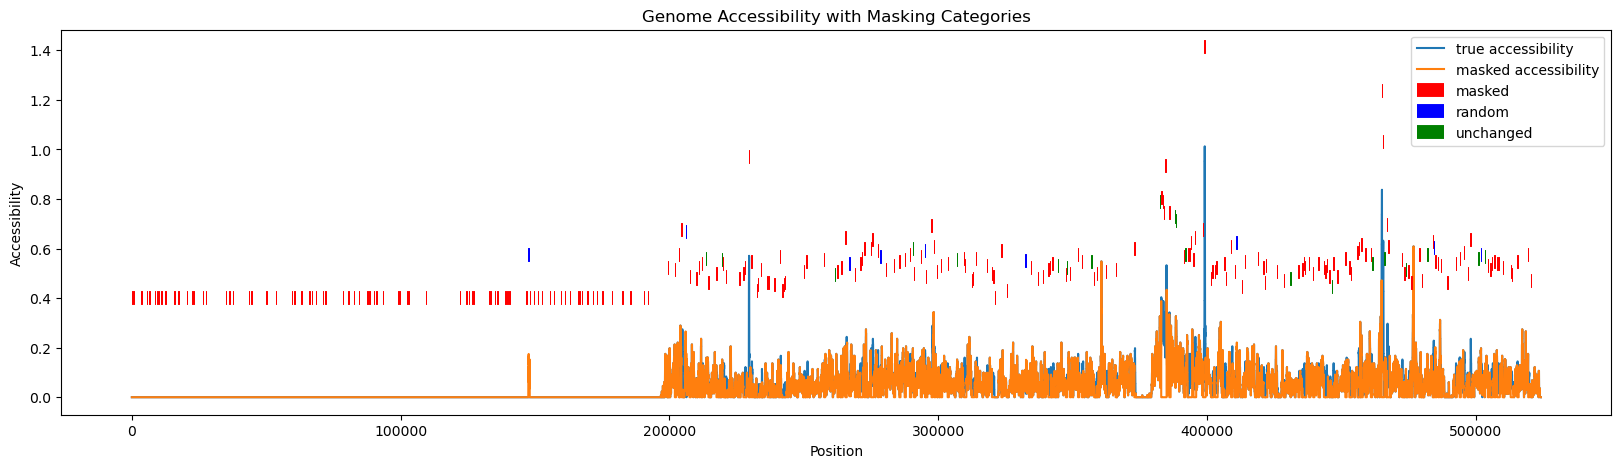

In [4]:
#this looks like a good mixx, many peaks masked, even smaller ones, but size doesn't fully determine if it's masked or not!!

#let's look at another region
#and let's look at the full plot
out = dataset[1022]
out_mask = dataset_mask_cont[1022]

chunk_size = 500
length = out_mask[1].shape[1]  # assuming out_mask[1] has shape (2, length)
num_chunks = length // chunk_size

# Define colors for each category
category_colors = {
    'masked': 'red',       # truly masked (80%)
    'random': 'blue',      # random replacement (10%)
    'unchanged': 'green'   # unchanged (10%)
}

plt.figure(figsize=(20, 5))
plt.plot(out[1][0].numpy(), label='true accessibility')
plt.plot(out_mask[1][0].numpy(), label='masked accessibility')

# To avoid duplicate legend entries
plotted_categories = set()

# Iterate over chunks
for i in range(num_chunks):
    start = i * chunk_size
    end = start + chunk_size

    # Only consider regions where out_mask[3]'s second row is 1 (evaluation region)
    if torch.all(out_mask[3][1, start:end] == 1):
        true_vals = out_mask[3][0, start:end].numpy()
        masked_vals = out_mask[1][0, start:end].numpy()

        # Determine the category for the chunk:
        if np.allclose(masked_vals, 0):
            category = 'masked'
        elif np.allclose(masked_vals, true_vals):
            category = 'unchanged'
        else:
            category = 'random'

        # Calculate y-value for the horizontal line: max value in chunk plus an offset
        y_line = max(np.max(true_vals), np.max(masked_vals)) + 0.4
        # y_line = -0.5
        
        # Only add the label once to avoid duplicates in the legend
        label = category if category not in plotted_categories else None
        plt.hlines(y_line, start, end, color=category_colors[category], linewidth=10, label=label)
        plotted_categories.add(category)

plt.legend()
plt.xlabel("Position")
plt.ylabel("Accessibility")
plt.title("Genome Accessibility with Masking Categories")
plt.show()

In [5]:
#clearly prefers peak regions, but not by a huge amount I guess... this is fine and good!!

#now let's verify that the values are what we exxpect, when masked it's something else, but if it's not masked it better be correct
#loop over the elements to verify
for i in range(out_mask[3].shape[1]):
    if out_mask[3][1,i] == 1: #indicates masked, whether masked or changed or unchanged, don't know, so skip
        continue
    assert torch.allclose(out_mask[1][:,i], out_mask[3][:,i]), f"Mismatch at position {i}: {out_mask[1][0,i]} != {out_mask[3][0,i]}"

In [ ]:
#yup, manually verified that it makes sense, I can now say confidently that this function sems to work and works decently too! Let's finally test some speed

dataset_mask_cont = GeneralDataset(
    split='train',
    preprocess=False,
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
    data_is_zarr=False,
    length=524288,
    load_in=True,
    mlm=0.25,  # increased masking percentage
    acc_mask=0.25,  # increased accessibility masking percentage
    weight_peaks=True  # weight peaks more (this is the new parameter we added to the dataset class
)
#have to laod in the dataset otherwise each iteration takes over a second, but by preloading it, we see this speed
from tqdm import tqdm
for i in tqdm(range(1000)):
    out = dataset_mask_cont[i]

#incredibly fast!! Not even a concern!!

100%|██████████| 1000/1000 [00:13<00:00, 72.06it/s]


In [8]:
#now testing the categorical values
#we need to evaluate to see how this works and if it makes sense, like if the thresholds work or make sense
#the threshold was set at 1
out_mask_cat[1].shape

torch.Size([3, 524288])

In [ ]:
out_mask_cat[3].sum(1) #peaks are not weighted! 131k is about correct! The first value is also 0, so we want row 1 which tells you it's accessible!

tensor([507368.,  16920., 131000.])

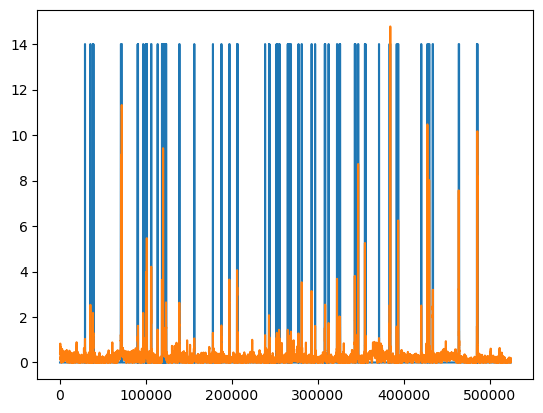

In [ ]:
plt.plot(out_mask_cat[3][1].numpy()*14)
plt.plot(out_mask_cont[3][0].numpy())
#clealry overlaps on values where it's gerater than 1, this seems to work exxaclty as we'd expect!!#and let's look at the full plot

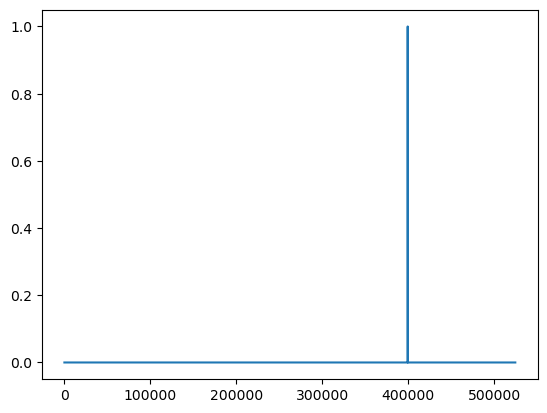

In [ ]:
out_mask = dataset_mask_cat[1022] #ahh a single accessible element
plt.plot(out_mask[3][1].numpy())

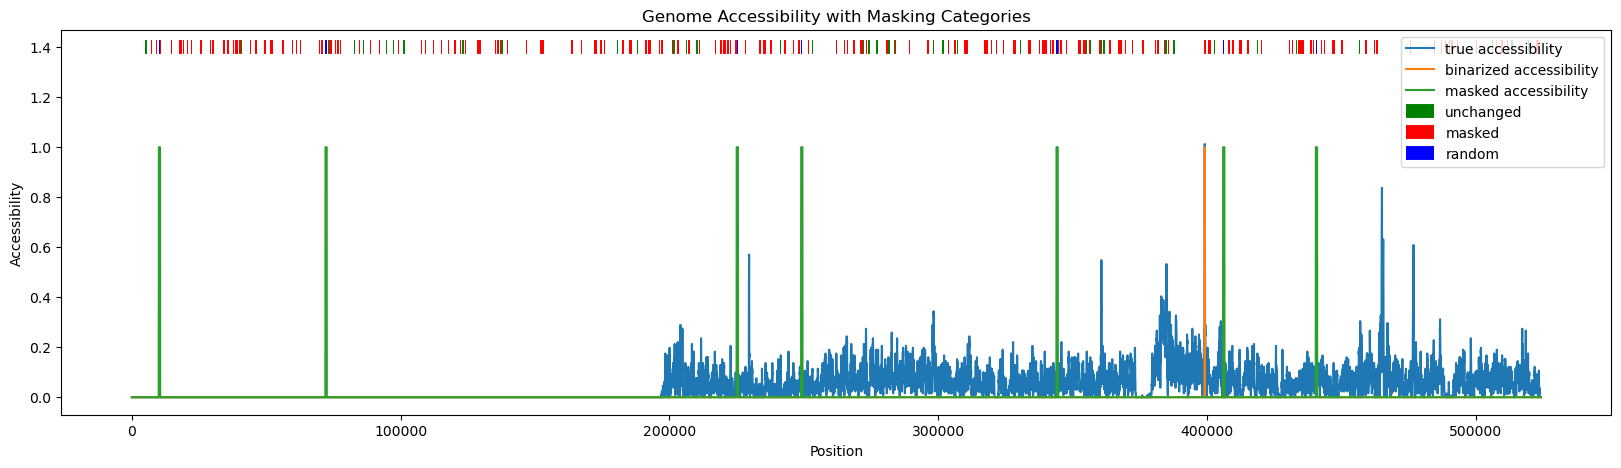

In [20]:
out = dataset[1022]
out_mask = dataset_mask_cat[1022]
#in this exxample true is all 0, noise adds some values that are 1!

chunk_size = 500
length = out_mask[1].shape[1]  # assuming out_mask[1] has shape (2, length)
num_chunks = length // chunk_size

# Define colors for each category
category_colors = {
    'masked': 'red',       # truly masked (80%)
    'random': 'blue',      # random replacement (10%)
    'unchanged': 'green'   # unchanged (10%)
}

plt.figure(figsize=(20, 5))
plt.plot(out[1][0].numpy(), label='true accessibility')
plt.plot(out_mask[3][1].numpy(), label='binarized accessibility')
plt.plot(out_mask[1][1].numpy(), label='masked accessibility')

# To avoid duplicate legend entries
plotted_categories = set()

# Iterate over chunks
for i in range(num_chunks):
    start = i * chunk_size
    end = start + chunk_size

    # Only consider regions where out_mask[3]'s second row is 1 (evaluation region)
    if torch.all(out_mask[3][2, start:end] == 1):
        true_vals = out_mask[3][:2, start:end].numpy()
        masked_vals = out_mask[1][:2, start:end].numpy()

        # Determine the category for the chunk:
        if np.allclose(masked_vals, 0):
            category = 'masked'
        elif np.allclose(masked_vals, true_vals):
            category = 'unchanged'
        else:
            category = 'random'

        # Calculate y-value for the horizontal line: max value in chunk plus an offset
        y_line = max(np.max(true_vals), np.max(masked_vals)) + 0.4
        # y_line = -0.5
        
        # Only add the label once to avoid duplicates in the legend
        label = category if category not in plotted_categories else None
        plt.hlines(y_line, start, end, color=category_colors[category], linewidth=10, label=label)
        plotted_categories.add(category)

plt.legend()
plt.xlabel("Position")
plt.ylabel("Accessibility")
plt.title("Genome Accessibility with Masking Categories")
plt.show()

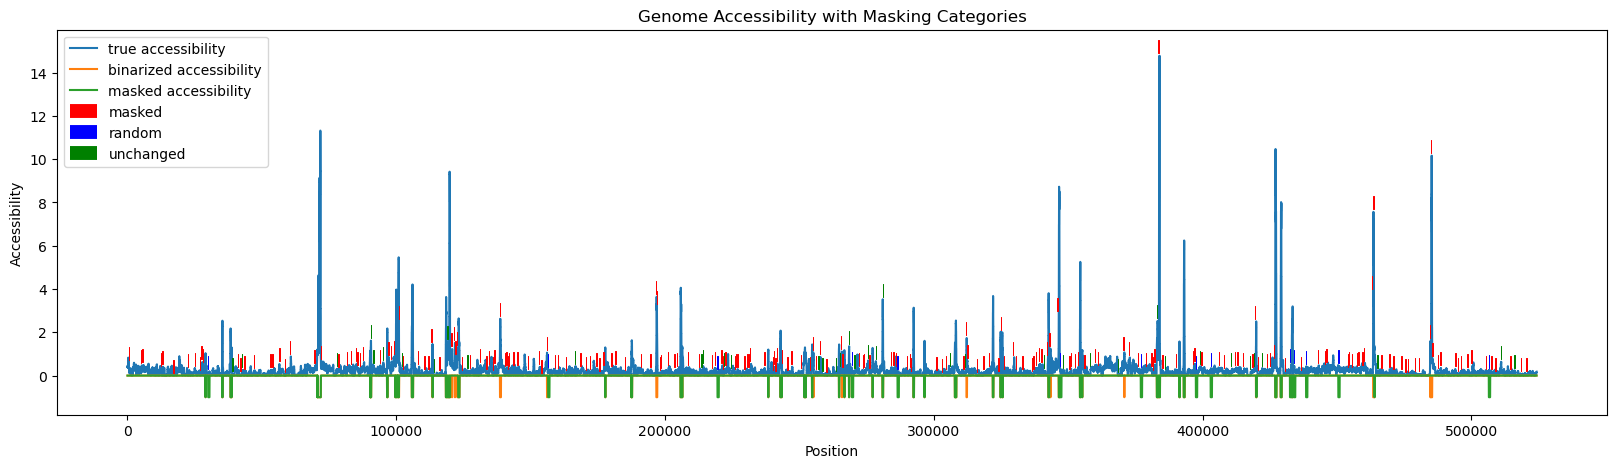

In [34]:
#this seems to work just fine!! let's test it on the other value

out = dataset[15]
out_mask = dataset_mask_cat[15]
#in this exxample true is all 0, noise adds some values that are 1!

chunk_size = 500
length = out_mask[1].shape[1]  # assuming out_mask[1] has shape (2, length)
num_chunks = length // chunk_size

# Define colors for each category
category_colors = {
    'masked': 'red',       # truly masked (80%)
    'random': 'blue',      # random replacement (10%)
    'unchanged': 'green'   # unchanged (10%)
}

plt.figure(figsize=(20, 5))
plt.plot(out[1][0].numpy(), label='true accessibility')
plt.plot(out_mask[3][1].numpy()*-1, label='binarized accessibility')
plt.plot(out_mask[1][1].numpy()*-1, label='masked accessibility')

# To avoid duplicate legend entries
plotted_categories = set()

# Iterate over chunks
for i in range(num_chunks):
    start = i * chunk_size
    end = start + chunk_size

    # Only consider regions where out_mask[3]'s second row is 1 (evaluation region)
    if torch.all(out_mask[3][2, start:end] == 1):
        true_vals = out_mask[3][:2, start:end].numpy()
        masked_vals = out_mask[1][:2, start:end].numpy()

        # Determine the category for the chunk:
        if np.allclose(masked_vals, 0):
            category = 'masked'
        elif np.allclose(masked_vals, true_vals):
            category = 'unchanged'
        else:
            category = 'random'

        # Calculate y-value for the horizontal line: max value in chunk plus an offset
        y_line = max(out[1][0,start:end]) + 0.4
        # y_line = -0.5
        
        # Only add the label once to avoid duplicates in the legend
        label = category if category not in plotted_categories else None
        plt.hlines(y_line, start, end, color=category_colors[category], linewidth=10, label=label)
        plotted_categories.add(category)

plt.legend()
plt.xlabel("Position")
plt.ylabel("Accessibility")
plt.title("Genome Accessibility with Masking Categories")
plt.show()

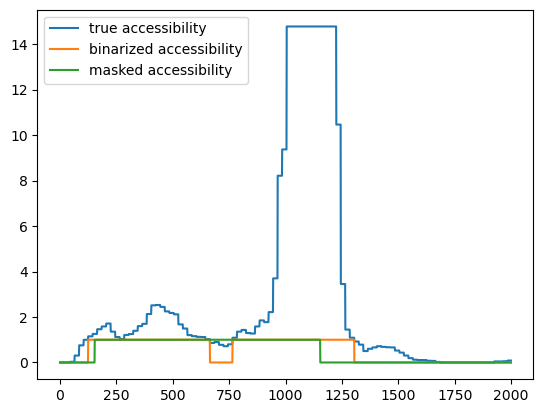

In [ ]:
#might randmoly sample peaks, so here it's ok not to weight, but regardless this looks good and like what we'd exxpect!!!!

start = 383851-5
plt.plot(out[1][0,start-1000:start+1000].numpy(), label='true accessibility')
plt.plot(out_mask[3][1,start-1000:start+1000].numpy(), label='binarized accessibility')
plt.plot(out_mask[3][2,start-1000:start+1000].numpy(), label='masked accessibility')
plt.legend()
#can see wher eit dips below one. This is good as well, I think we're save to say this works!! j

In [42]:
#final thing is go through adn verify that if not masked, it's identical between them and that the out value is greater than 1
#loop over the elements to verify
for i in range(out_mask[3].shape[1]):
    if out_mask[3][2,i] == 1: #indicates masked, whether masked or changed or unchanged, don't know, so skip
        continue
    assert torch.allclose(out_mask[1][:,i], out_mask[3][:,i]), f"Mismatch at position {i}: {out_mask[1][0,i]} != {out_mask[3][0,i]}"
    if out_mask[3][1,i]>0:
        assert out[1][0,i] >= 1, f"Value at position {i} is less than 1: {out[1][0,i]}"

In [ ]:
#final thing, speed test!

dataset_mask_cat = GeneralDataset(
    split='train',
    preprocess=False,
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
    data_is_zarr=False,
    sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
    length=524288,
    load_in=True,
    mlm=0.25,  # increased masking percentage
    acc_mask=0.25,  # increased accessibility masking percentage
    acc_type='category',  # categorical accessibility values
)
#have to laod in the dataset otherwise each iteration takes over a second, but by preloading it, we see this speed
from tqdm import tqdm
for i in tqdm(range(1000)):
    out = dataset_mask_cat[i]
#pretty much the same sped, slightly slower, but basically fine!!

100%|██████████| 1000/1000 [00:16<00:00, 59.03it/s]


In [ ]:
#so overall this works, I think we can rellatively confidently say that it works as expected, and gives us stuff that we think it does

In [ ]:
#the last thing we need to do with our dataset is figure out how to get it to work when we have multiple tracks, all this is 1 track, if more than 1, we dont' know what to do...   

In [ ]:
#also really quickly let's tuirn npz files to zarr files, seems there's some issues?

